In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

from nltools.external import glover_hrf, spm_hrf
from sklearn.linear_model import LinearRegression
import seaborn as sns

import pandas as pd
import os

import nibabel as nb
from nilearn import datasets
from nilearn import plotting, image
from nilearn.glm.first_level import make_first_level_design_matrix, FirstLevelModel
from nltools.data import Design_Matrix, Brain_Data
from nilearn.image import index_img

from nltools.stats import regress, zscore

/home/seojin/anaconda3/envs/seojin/lib/python3.9/site-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)
/home/seojin/anaconda3/envs/seojin/lib/python3.9/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "



# Model

## Deterministic Model
Y = f(x)
변수의 관계가 수학적 함수관계에 있는 모델

## Statistical Model
Y = f(x) + ε
변수들 간의 관계에 오차를 허용하는 모델

### 통계적 모형을 생각하는 이유?
(1) 변수의 관계가 수학적 함수 관계에 있다고 하더라도 관측시에는 여러가지 잡음으로 인하여 설정된 함수 관계가 완벽하지 만족되지 않는다.

(2) 변수들간의 관계가 정확하게 알려져 있지 않거나, 또는 알려져 있다고 하더라도 복잡한 형태로 주어지는 경우 근사적 모형을 사용한다.


# Regression
Regression이라는 용어는 Francis Galton의 아버지의 키와 아들의 키의 관계를 분석한 논문에서 처음 사용되었다.
아들들의 키를 분석한 이 논문에서 아들들의 키는 아버지들의 키를 닮아 가는 경향과 함께 사람들의 평균키에 가까이 갈려는 현상이 있음을 밝혔다.
구체적으로, 평균키보다 큰 아버지들의 집단에서 태어난 아들들의 키의 평균은 전체 아들들의 평균키보다는 크지만 아버지들들의 평균키보다는 작으며, 이와 반대로  평균키보다 작은 아버지들의 집단에서 태어난 아들들의 키의 평균은 전체 아들들의 평균키보다는 작지만 아버지들의 평균키보다는 크게 됨으로서 사람들의 키는 항상 균형을 유지하게 된다는 것이다. 이를 갤튼은 평범으로의 회귀라고 설명하였다.

갤튼이 아버지의 키와 아들의 키의 관계를 분석한 것과 같이 변수들의 관계를 분석하는 방법을 회귀분석이라 일컫게 되었으나, 실제 회귀라는 용어는 분석방법과는 전혀 관계가 없는 용어이다.


# Simple linear regression Regression

단 하나의 설명변수만을 다루는 것을 의미한다.
선형이라는 의미는 회귀식이 설명변수의 일차식으로 주어짐을 의미한다.

$$ Y_i = β_0 + β_1X + ε_i $$ 

위 식에서 오차항은 평균이 0, 분산이 $σ^2$임을 가정한다.

데이터가 다음과 같이 주어지는 경우를 생각해보자.

x = [0, 1, 2]
y = [5, -4, 102]

Text(0, 0.5, 'Y')

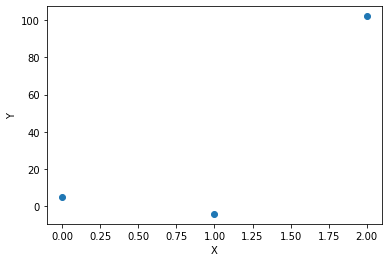

In [2]:
x = np.array([0,1,2])
y = np.array([5, -4, 102])

plt.scatter(x, y);
plt.xlabel("X")
plt.ylabel("Y")

In [3]:
x, y

(array([0, 1, 2]), array([  5,  -4, 102]))

위와 같은 데이터가 있다고 가정하자.
이러한 데이터를 선형 회귀식을 사용하여 다음과 같이 나타낼 수 있다.

$$ Y_1 = β_0 + β_1X + ε_1 $$ 
$$ Y_2 = β_0 + β_1X + ε_2 $$ 
$$ Y_3 = β_0 + β_1X + ε_3 $$ 

실제 값으로 대입하면,
$$ 5 = β_0 + β_1 * 0 + ε_1 $$ 
$$ -4 = β_0 + β_1 * 1 + ε_2 $$ 
$$ 102 = β_0 + β_1 * 2 + ε_3 $$ 

만약 $ β_0 = 0, β_1 = 1 $ 이라고 가정하자.
그러면 
$$ 5 = 0 + 1 * 0 + ε_1 $$ 
$$ -4 = 0 + 1 * 1 + ε_2 $$ 
$$ 102 = 0 + 1 * 2 + ε_3 $$

이 되고, 이를 오차항으로 표현하면
$$ ε_1 = 0 + 1 * 0 - 5 = -5 $$ 
$$ ε_2 = 0 + 1 * 1 + 4 = 5 $$ 
$$ ε_3 = 0 + 1 * 2 - 102 = -100 $$

잔차를 모두 합하면 -100 이 된다.
이를 절대값으로 표현하면 100이고 이 의미는 내가 가정한 모델의 파라미터 $(β_0, β_1) $ 가 100만큼의 오차가 난다는 뜻이 된다.

우리의 목표는 다음의 그림처럼 이러한 오차가 최대한 적게나는 모델을 만드는 것이다.


Model slope:     48.5
Model intercept: -14.17
Y_i:  48.5 * x_i + -14.17


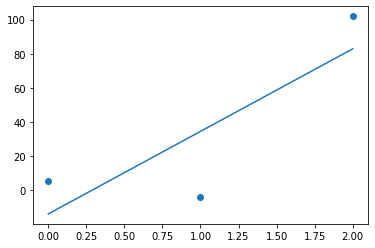

In [4]:
model = LinearRegression(fit_intercept=True)

model.fit(x[:, np.newaxis], y)

xfit = np.linspace(0, 2)
yfit = model.predict(xfit[:, np.newaxis])

plt.plot(xfit, yfit);
plt.scatter(x, y)

slope = np.round(model.coef_[0], 2)
intercept = np.round(model.intercept_, 2)
print("Model slope:    ", slope)
print("Model intercept:", intercept)
print("Y_i: ", slope, "* x_i", "+", intercept)

# Estimation Regression coefficient

## 목표
우리의 목표는 기울기와 절편을 잘 근사하여 모집단을 잘 설명할 수 있는 모집단회귀선과 같은 선을 그어 자료에 대한 모형을 만드는 것이다.

## Error
Error는 모집단회귀식과 관측치의 차이이다.
$$ ε_i = Y_i - β_0 + β_1X_i $$

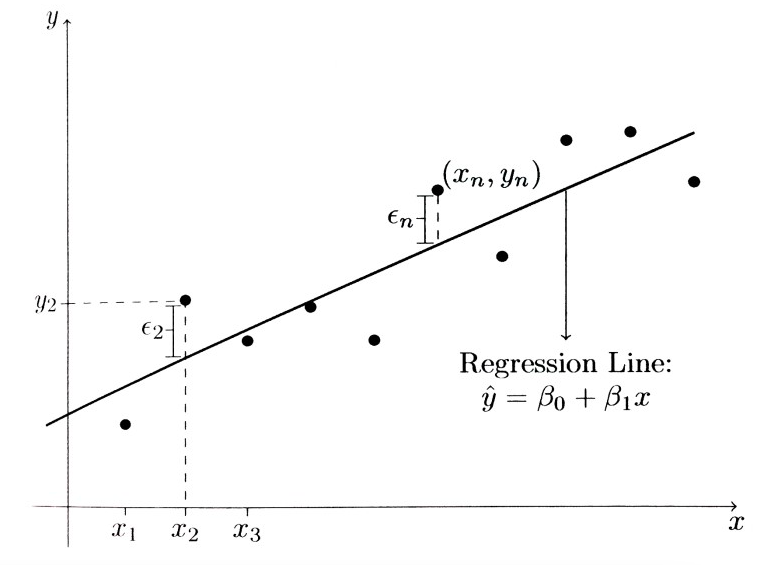

## Least Squares Estimation(LSE)
관측된 Y값과 모집단회귀식간에는 $ β_0 + β_1X_i $ 만큼의 차이가 있으므로 $ ε_i $ 만큼의 차이가 있으므로 만일 이 차이를 가장 작게하여 줄 수 있는 직선이 있으면 그것이 가장 이상적인 회귀식이라 할 수 있다. 그러나 모든 점에서 오차의 값을 최소화할 수는 없으므로 오차의 크기를 "전체적"으로 작게 하는 방법을 선택하여하 한다. 이러한 방법들 중 가장 널리 사용되는 것이 최소제곱법이다.

위에서 다음과 같은 선형 회귀식을 생각하였다.
$$ Y_1 = β_0 + β_1X + ε_1 $$ 
$$ Y_2 = β_0 + β_1X + ε_2 $$ 
$$ Y_3 = β_0 + β_1X + ε_3 $$ 

그런데 우리의 목표는 오차가 가장 적게나는 모델을 만드는 것이므로 위 식을 오차항으로 정리하면 다음과 같다.
$$ ε_1 = Y_1 - (β_0 + β_1X) $$ 
$$ ε_2 = Y_2 - (β_0 + β_1X) $$ 
$$ ε_3 = Y_3 - (β_0 + β_1X) $$ 

### 오차제곱의 합
LSE는 오차제곱의 합이 최소화 되는 기울기와 절편을 찾는다.
$$ S = \sum_{i=1}^{n}ε_i^2 $$
$$ S = \sum_{i=1}^{n}(Y_i - \hat{Y_i})^2 $$
$$ S = \sum_{i=1}^{n}(Y_i - β_0 - β_1X_i)^2 $$

### 최적점 구하기
이차함수의 최적점은 기울기가 0이 되는 지점이다.

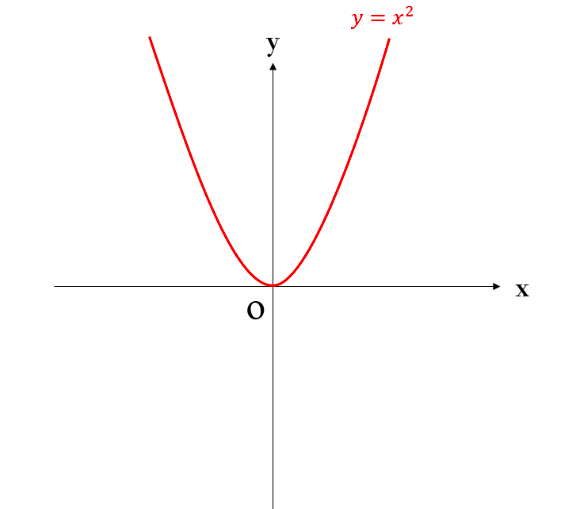

$$ \frac{∂S}{∂β_0} = \frac{∂\sum (Y_i - β_0 - β_1X_i)^2}{∂β_0} $$
$$ \frac{∂S}{∂β_0} = \sum (\frac{∂(Y_i - β_0 - β_1X_i)^2}{∂β_0} ) $$
$$ \frac{∂S}{∂β_0} = \sum 2 * (-1) * (Y_i - β_0 - β_1X_i) $$

편미분하여 나오는 값을 0으로 놓으면 최적점을 찾을 수 있다.

$$ \frac{∂S}{∂β_0} = \sum 2 * (-1) * (Y_i - β_0 - β_1X_i) = 0 $$

위 식을 정리하면,
$$ \color{red}{(1) \sum{Y_i} = nβ_0 + β_1\sum{X_i}} $$

마찬가지로, $ β_1 $에 대해서 정리하면,

$$ \frac{∂S}{∂β_1} = \frac{∂\sum (Y_i - β_0 - β_1X_i)^2}{∂β_1} $$
$$ \frac{∂S}{∂β_1} = \sum (\frac{∂(Y_i - β_0 - β_1X_i)^2}{∂β_1} ) $$
$$ \frac{∂S}{∂β_1} = \sum 2 * (-1) * (Y_i - β_0 - β_1X_i)X_i $$

편미분하여 나오는 값을 0으로 놓으면 최적점을 찾을 수 있다.

$$ \frac{∂S}{∂β_1} = \sum 2 * (-1) * (Y_i - β_0 - β_1X_i)X_i $$

위 식을 정리하면,
$$ -2 * [\sum{X_iY_i} - β_0\sum{X_i} - β_1\sum{X_i^2}] = 0$$

$$ \color{red}{(2) \sum{X_iY_i} = β_0\sum{X_i} + β_1\sum{X_i^2}} $$

추정량 $ \hat{β_0} $와 $ \hat{β_1} $은 위의 두 식을 만족하는 $ β_0, β_1 $ 으로 주어지므로 위의 식에서 $ \hat{β_0} $와 $ \hat{β_1} $을 대입하고 정리한다.

$$ (1) \sum{Y_i} = n\hat{β_0} + \hat{β_1}\sum{X_i} $$
$$ (2) \sum{X_iY_i} = \hat{β_0}\sum{X_i} + \hat{β_1}\sum{X_i^2} $$

첫 번째 식에서 양변을 n으로 나눈 다음 $ \hat{β_0} $에 대해 나타내면,

$$ \hat{β_0} = \overline{Y} - \hat{β_1}\overline{X} $$

(2)에 의해,
$$ \sum{X_iY_i} = \hat{β_0}\sum{X_i} + \hat{β_1}\sum{X_i^2} $$

$$ \sum{X_iY_i} = (\overline{Y} - \hat{β_1}\overline{X})n\overline{X} + \hat{β_1}\sum{X_i^2} $$

$$ \sum{X_iY_i} = (\sum{X_i^2} - n\overline{X}^2)\hat{β_1} + n\overline{X}\overline{Y} $$

$$ \hat{β_1} = \frac{\sum{X_iY_i} - n\overline{X}\overline{Y}}{\sum{X_i^2} - n\overline{X}^2} $$

$$ \hat{β_1} = \frac{\sum{(X_i - \overline{X})(Y_i - \overline{Y_i})}}{{\sum{(X_i - \overline{X})^2}}} $$

정리하면,
$$ \hat{β_0} = \overline{Y} - \hat{β_1}\overline{X} $$

$$ \hat{β_1} = \frac{\sum{(X_i - \overline{X})(Y_i - \overline{Y})}}{{\sum{(X_i - \overline{X})^2}}} $$

β_1 식을 간주려서 나타내면 다음과 같다.

$$ \hat{β_1} = \frac{S_{XY}}{S_{XX}} $$

///////////////////////////////////////////////////////////////////////////////////////////////  
*참고 Sxy, Sxx는 다음과 같다.  
$$ S_{XY} = \sum{(X_i - \overline{X})(Y_i - \overline{Y})} $$ 
$$ S_{XX} = \sum{(X_i - \overline{X})^2} $$ 

///////////////////////////////////////////////////////////////////////////////////////////////


## Residual
Residual은 적합오차로 관측치 Y_i가 적합된 회귀직선에서 떨어져 있는 정도를 나타낸다. ※ $ \hat{Y_i} = \hat{Β_0} + \hat{Β_1}Χ $
$$ e_i = Y_i - \hat{Y_i} $$

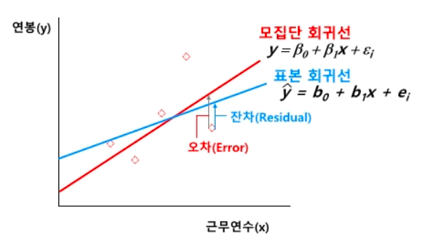

그러나 실제로 오차를 제일 적게하는 직선을 찾으면 좋겠지만 오차라는 것은 모집단 전체를 대변하는 용어이므로 구할 수 없다. LSE에서 Error 대신에 Residual을 사용한다. 그 이유는 회귀분석에서 Error $ ε_i $는 관측할 수 없는 값이지만, Residual $ e_i $는 표본을 이용하여 회귀식이 적합(fit)되면 계산할 수 있는 값이기 때문이다.

표본 자료를 이상적으로 표현하는 표본회귀선을 찾기 위해서는 잔차의 정도가 최소가 되는 표본회귀선을 구하면 된다.

흔히들 회귀선의 오차항을 구해야 한다고 하지만 사실상 모회귀선의 오차항을 구하기 위해서 그 오차항의 추정치인 표본회귀선의 잔차를 구해야 한다.



# 행렬 표현

다음과 같은 데이터의 회귀식을 행렬로 쉽게 표현할 수 있다.
$$ Y_1 = β_0 + β_1X + ε_1 $$ 
$$ Y_2 = β_0 + β_1X + ε_2 $$ 
$$ Y_3 = β_0 + β_1X + ε_3 $$ 

행렬의 장점은 연립방정식을 간략하게 표현할 수 있다는 것에 있다.

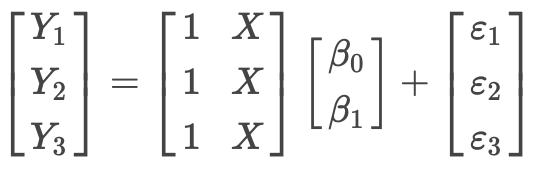

이는 간략하게 다음과 같이 표현된다.

$$ Υ = Χβ + ε $$

오차는 다음과 같이 표현된다. 
$$ ε = Y - Xβ $$

오차 제곱합은 다음과 같이 표현된다.

$$ S = ε'ε = (Y - Xβ)'(Y - Xβ) $$

$$ S = ε'ε = Y'Y - Y'Xβ -β'X'Y + β'X'Xβ $$

이에 대하여 β의 최적점을 구하기 위해 미분하면

///////////////////////////////////////////////////////////////////////////////////////////////  
*참고 vector 미분은 다음과 같다. $ \frac{∂(f(x)'g(x))}{∂x} = \frac{∂f(x)}{∂x}g(x) + f(x)\frac{∂g(x)}{∂x} $  
///////////////////////////////////////////////////////////////////////////////////////////////

$$ \frac{∂S}{∂β} = \frac{∂(Y'Y)}{∂β} - \frac{∂(Y'Xβ)}{∂β} - \frac{∂(β'X'Y)}{∂β} + \frac{∂((Xβ)'Xβ)}{∂β} $$

$$ \frac{∂S}{∂β} = 0 - X'Y - y'X + X'(XB) + (XB)'X $$

dot product는 교환법칙이 성립하므로

$$ \frac{∂S}{∂β} = 0 - 2X'Y + 2X'(XB) $$

위 식에서 β 대신에 $ \hat{β} $ 를 대입한 후 0으로 놓으면

$$ (X'X)\hat{β} = X'Y $$

이를 β에 관하여 정리하면 

$$ \hat{β} = (X'X)^{-1}X'Y $$

# Multiple Linear regression

두가지 변수가 사용되는 경우를 생각해보자.



$$ Y_1 = β_0 + β_1X_1 + β_2X_2 + ε_1 $$ 
$$ Y_2 = β_0 + β_1X_1 + β_2X_2 + ε_2 $$ 
$$ Y_3 = β_0 + β_1X_1 + β_2X_2 + ε_3 $$ 

이를 행렬로 표현하면 다음과 같다.

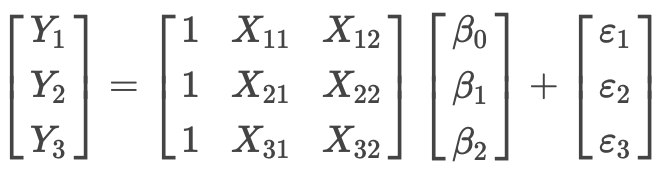

이 회귀식의 최적점 β는 위에서 나온 식을 통해 구할 수 있다.

$$ \hat{β} = (X'X)^{-1}X'Y $$

위의 식과 같은 X를 Design matrix라고 부른다.


다음과 같은 데이터가 있다고 해보자.

X1 = [0, 1, 2]  
X2 = [3, 4, 5]  
Y = [5, -4, 102]

이에 대한 회귀선을 다음의 코드를 이용하여 구할 수 있다.


[[0 3]
 [1 4]
 [2 5]]


/tmp/ipykernel_507621/1430777089.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection="3d")


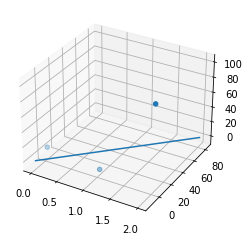

In [5]:
fig = plt.figure()
ax = fig.gca(projection="3d")

X1 = [0, 1, 2]
X2 = [3, 4, 5]
Y = [5, -4, 102]

X = np.array([X1, X2])
X = X.T
print(X)

ax.scatter(X[:,0], X[:,1], Y)

model = LinearRegression(fit_intercept=True)
model.fit(x[:, np.newaxis], y)

xfit = np.linspace(0, 2)
yfit = model.predict(xfit[:, np.newaxis])

plt.plot(xfit, yfit);


# Experiment Design

## Block design
비슷한 event를 그룹화하여 일정시간동안 지속시키는 설계 방법을 의미한다.


## Event-related design
event의 여러 유형이 서로 섞이는 설계 방법을 의미한다.

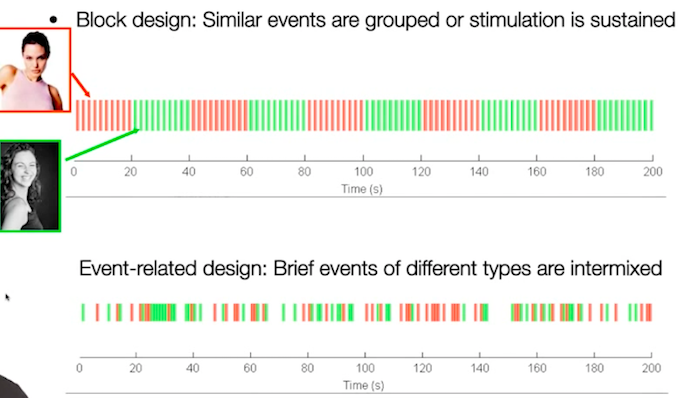

Image was taken from the following site. 

Principles of the fMRI Part 1 (https://youtu.be/OyLKMb9FNhg)

# Simulate a voxel time course

참고: https://dartbrains.org/content/GLM.html

Voxel 하나를 simulation 해보자

총 실험시간은 206초이고, 얼굴과 사물을 자극으로 보여주었다고 하자.
첫번째 자극은 6초에 시작되고, 자극의 지속시간은 6초이다. 그리고 fMRI tr은 2초였다. 그리고 각 자극간의 간격은 14초라고 하자.

또, 이 voxel은 face에 대해 더 예민한 반응을 보인다고 가정하자.

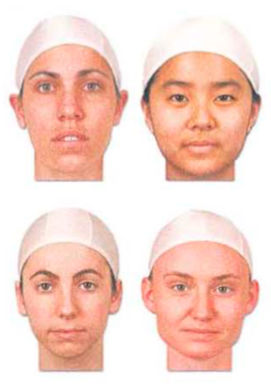
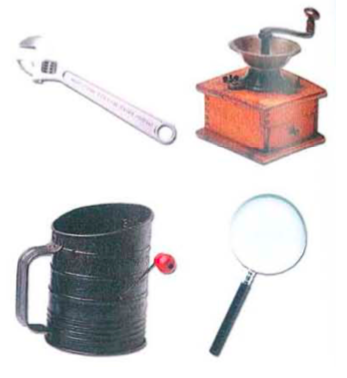

In [6]:
def plot_timeseries(data, exp_cnt, labels=None, linewidth=3):
    '''Plot a timeseries
    
    Args:
        data: (np.ndarray) signal varying over time, where each column is a different signal.
        labels: (list) labels which need to correspond to the number of columns.
        linewidth: (int) thickness of line
    '''
    plt.figure(figsize=(20,5))
    plt.plot(data, linewidth=linewidth)
    plt.ylabel('Intensity', fontsize=18)
    plt.xlabel('Time', fontsize=18)
    plt.tight_layout()
    plt.xticks(np.arange(0, exp_cnt, 5))
    if labels is not None:
        if len(labels) != data.shape[1]:
            raise ValueError('Need to have the same number of labels as columns in data.')
        plt.legend(labels, fontsize=18)

In [7]:
category_count = 2 # Face, Object

total_trial = 10 # Total stimulus trial

tr = 2 # 2 seconds
empty_time = 6 # 6 seconds
stimulus_time = 6 # 6 seconds
stimulus_rest_time = 14 # 6 seconds
trial_time = stimulus_time + stimulus_rest_time # 20 seconds
exp_times = empty_time + trial_time * total_trial # 206 seconds

n_volumes = exp_times / tr # 1 Volume means that a single 3D representation of Brain

In [8]:
def boxcar_design(start_time, exp_times, intensity, stimulus_time, trial_time):
    stimulus = np.zeros(exp_times)
    for i in np.arange(start_time, exp_times, trial_time*2):
        i = int(i)
        stimulus[i:i+stimulus_time] = intensity
        
    return stimulus

Face image를 자극으로 보여주었을때, 모형은 다음과 같다.

이 voxel은 face에 더 민감하게 반응한다고 가정하였으므로 intensity를 2로 설정하였다.

<Figure size 432x288 with 0 Axes>

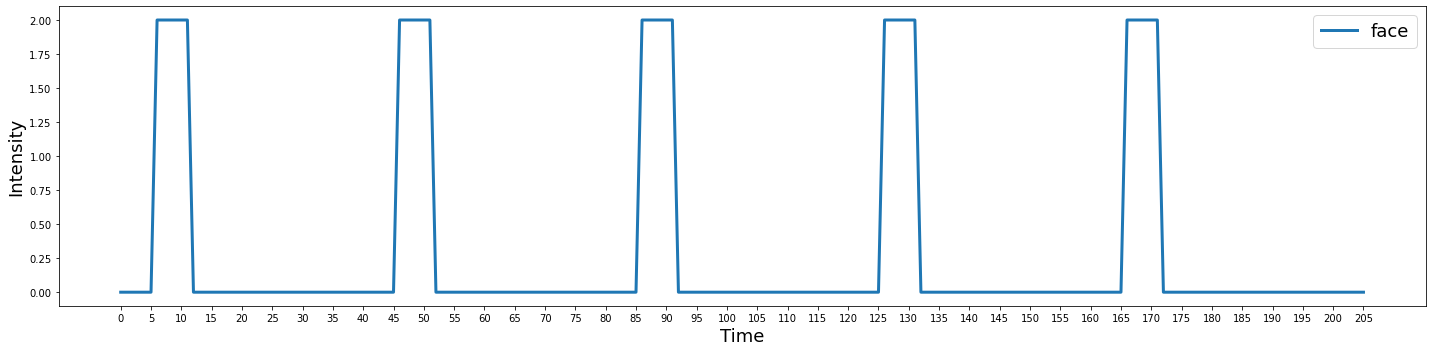

In [9]:
plt.clf()

face_intensity = 2
face_start_time = 6

face = boxcar_design(face_start_time, exp_times, face_intensity, stimulus_time, trial_time)
plot_timeseries(face, exp_times)

plt.legend(["face"], fontsize=18)

plt.show()

사물 이미지를 자극으로 보여주었을때, 모형은 다음과 같다.

이 voxel은 object에 덜 민감하게 반응한다고 가정하였으므로 intensitiy를 1로 두었다.

<Figure size 432x288 with 0 Axes>

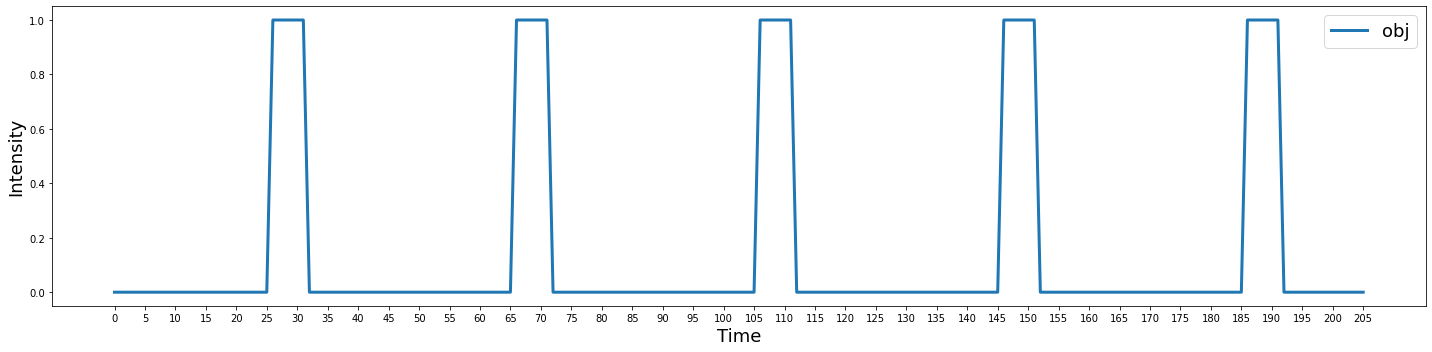

In [10]:
plt.clf()
obj_intensity = 1
object_start_time = face_start_time + trial_time

obj = boxcar_design(object_start_time, exp_times, obj_intensity, stimulus_time, trial_time)
plot_timeseries(obj, exp_times)

plt.legend(["obj"], fontsize=18)
plt.show()

두 카테고리를 합친 모형은 다음과 같다.

<Figure size 432x288 with 0 Axes>

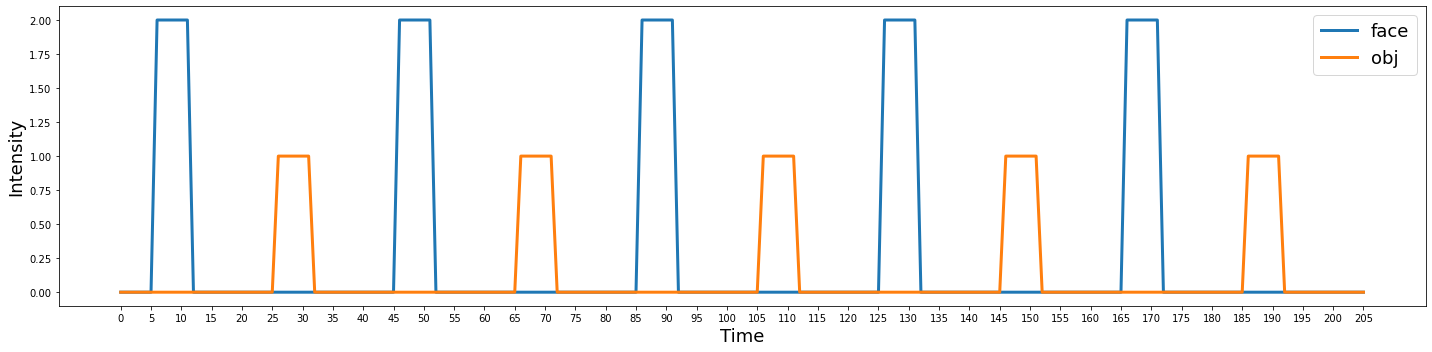

In [11]:
plt.clf()
categories = np.vstack([face,obj]).T
plot_timeseries(categories, exp_times)

plt.legend(["face", "obj"], fontsize=18)
plt.show()

## Hemodynamic delay

voxel에 어떤 자극을 가하면, blood oxygen level이 처음에 내려간다.
이를 initial dip이라고 하는데, initial dip 이후에 소비된 산소를 보상하기 위하여 overcompensate 현상이 일어난다.
이는 아주 느리고 길게 일어나는데, 4~6초 뒤에 peak를 찍은 후 포화도가 점점 내려가서 undershoot에 이르게 된다.

이러한 현상은 brain을 관찰하는데 좋은 도구가 되는데, blood oxygen이 neural activity를 표현하고 있다고 생각되기 때문이다.


다음 이미지는 다음 강의에서 참조되었다.

fMRI bootcamp (https://www.youtube.com/watch?v=SsJjuJJjNHM&list=PLyGKBDfnk-iDVpUGSR_GlDmQrZOS0Lk6k&index=2)

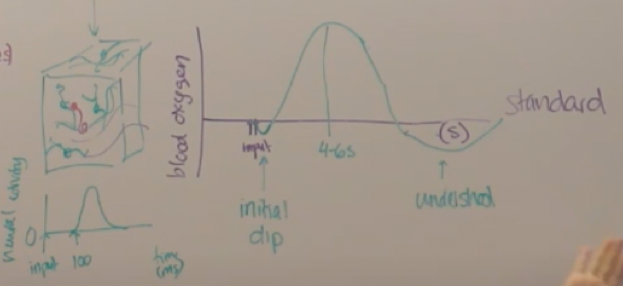

다음 이미지는 Principles of fMRI Part1 강의를 참조하였다.

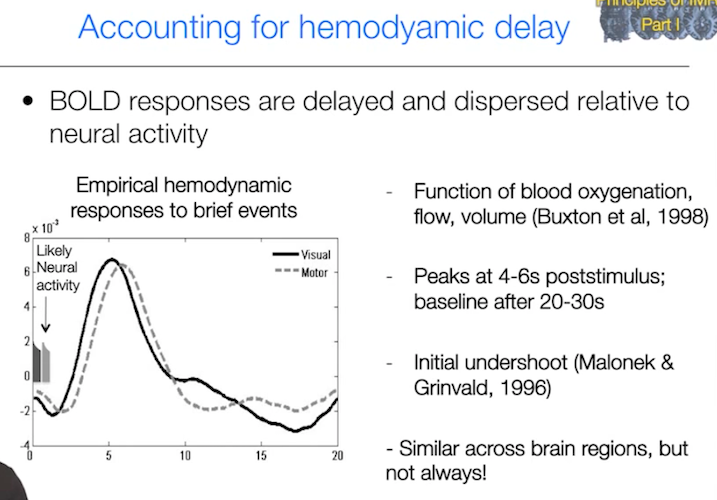

## Hemodynamic Response function

Hemodynamic delay를 모사한 함수이다.(감마함수를 이용해 모사)

brain activity를 simulation하기 위해 위의 모형에 Hemodynamic Response function을 convolution 하자.

Text(0.5, 0, 'Time')

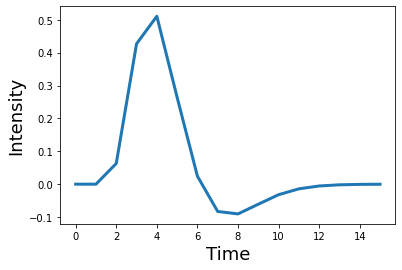

In [12]:
# Hemodynamic Response Function(HRF)
hrf = glover_hrf(tr, oversampling=1)
plt.plot(hrf, linewidth=3)
plt.ylabel('Intensity', fontsize=18)
plt.xlabel('Time', fontsize=18)

## Linear Time Invariant(LTI) system

Neural activity를 GLM에서 모사하기 위하여 LTI System을 가정한다.
즉, input을 impulse function과 hemodynamic response function h(t)와 convolution하여 만든다.

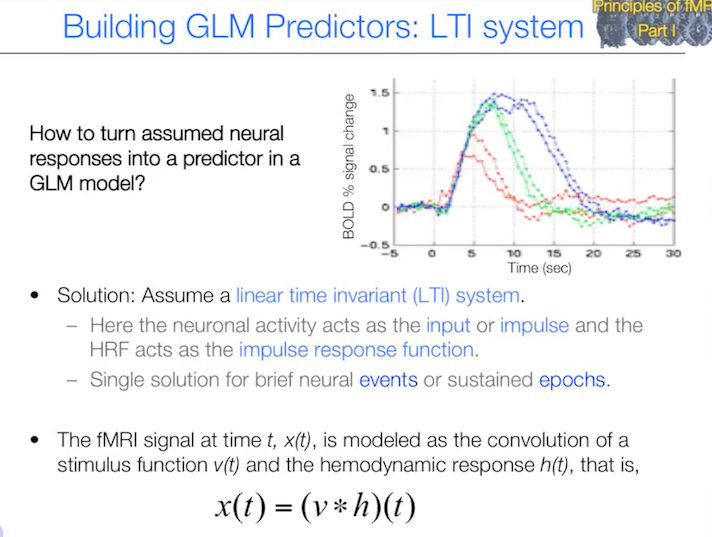

참고: 
https://www.youtube.com/watch?v=XsP3DGHwYf0
https://www.youtube.com/watch?v=uXl_QTsTj-w&t=1383s

LTI 시스템은 scaling + addictivity와 Time invariant를 만족하는 system을 의미한다.

### Scaling
어떤 입력 x(t)에 대하여 시스템이 y(t)를 출력한다면, 시스템에 입력을 scaling 한 입력을 넣는다면, 출력이 y(t)에 대해 scaling한 값이 나오는 것을 의미한다.

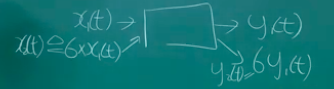

### Additivity
어떤 입력 x1(t)와 x2(t)가 합쳐져서 들어갔을때, 출력이 그에 대응하는 y1(t)와 y2(t)의 합으로 나오는것을 의미한다.

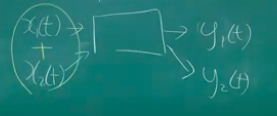

### Time invariant
어떤 신호를 shift 시켰다면, 출력도 그만큼 shift되는 것을 의미한다.

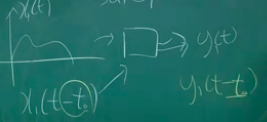

## Convolution

다음과 같은 함수를 의미한다.

여기서 t는 시간, x(t)는 input, h(t)는 single impulse가 주어졌을때, 반응하는 정도를 의미한다.

이를 통해서 누적된 반응을 계산할 수 있다.

$$ y(t) = f( x(t), h(t) ) $$

## Impulse function

0에서 1이 되고 나머지 지점에 대해서는 0이 되는 함수를 의미

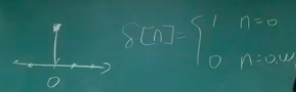

## Impulse response function

Impulse에 대응하는 함수이다. h로 표현한다.

$$ δ -> system -> h $$

## DT Convolution
Discrete Time convolution

### Signal can be expressed by sum of impulse
다음 그림처럼 한 signal은 impulse function의 합으로 표현 될 수 있다.
x는 intensity를 의미

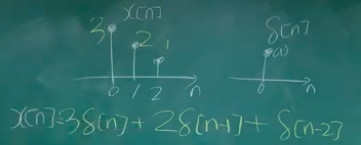

이를 일반화하면 다음과 같다.
$$ x[n] = \sum_{k=-∞}^{∞}x[k]δ[n-k] $$

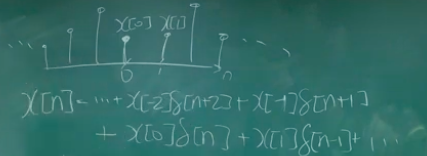

### Response can be expressed by sum of Impulse response function

input이 impulse function의 합으로 표현된다면, LTI system에서는 출력을 Impulse response function의 합으로 표현할 수 있다.

여기서 x[k]는 scaling을 의미하며,
sum은 addictivity를 의미하고, n-k는 Time invariant를 의미한다.

$$ y[n] = \sum_{k=-∞}^{∞}x[k]h[n-k] $$

Hemodynamic response를 모사하는 impulse response function은 다음과 같다.

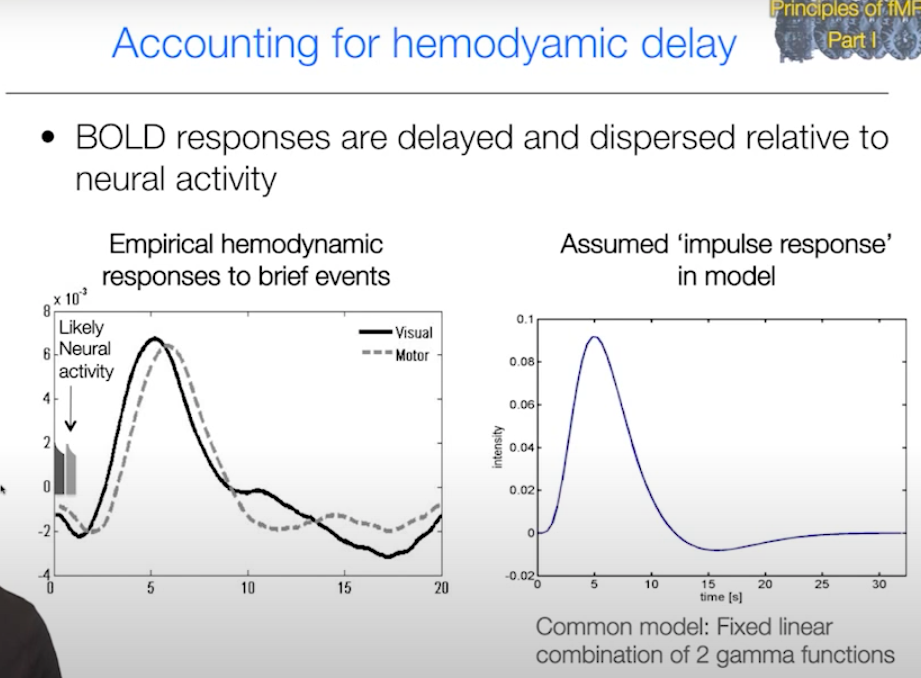

LTI system의 Addictivity 성질에 의해 신호가 겹쳐지면 더 큰 신호가 나타난다.

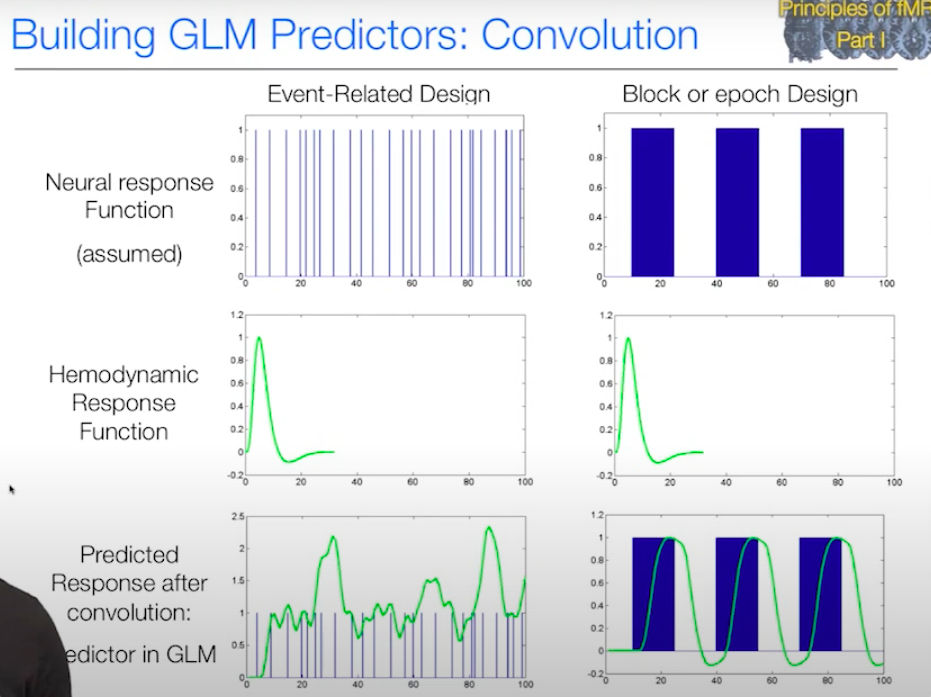

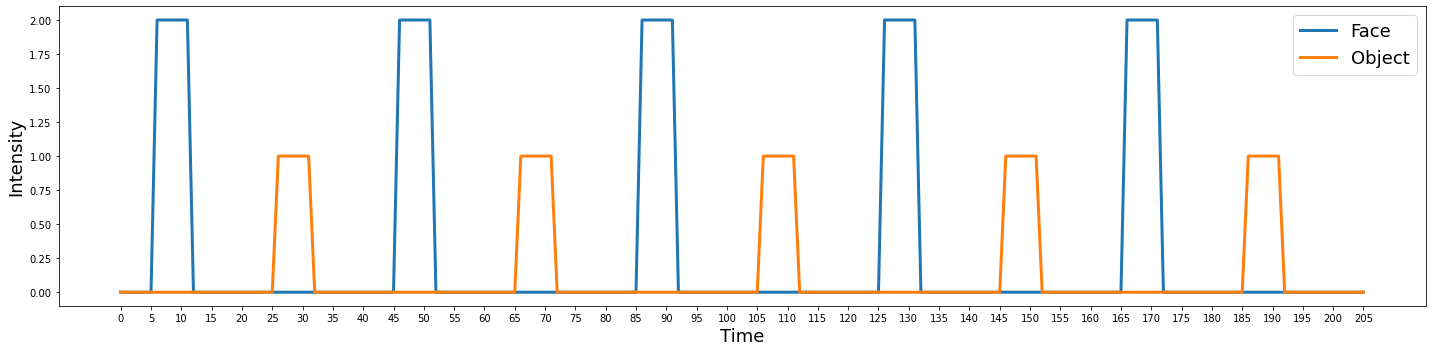

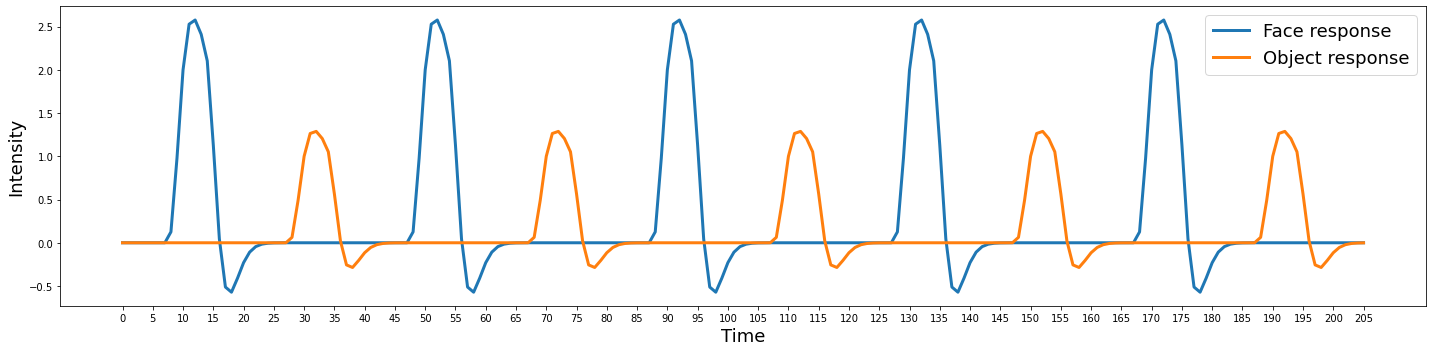

In [13]:
## Convolution
face_conv = np.convolve(face, hrf)[:len(face)]
obj_conv = np.convolve(obj, hrf)[:len(obj)]
categories_conv = np.vstack([face_conv, obj_conv]).T

plot_timeseries(np.c_[face, obj], exp_times, labels =["Face", "Object"])
plot_timeseries(categories_conv, exp_times, labels=['Face response', 'Object response'])

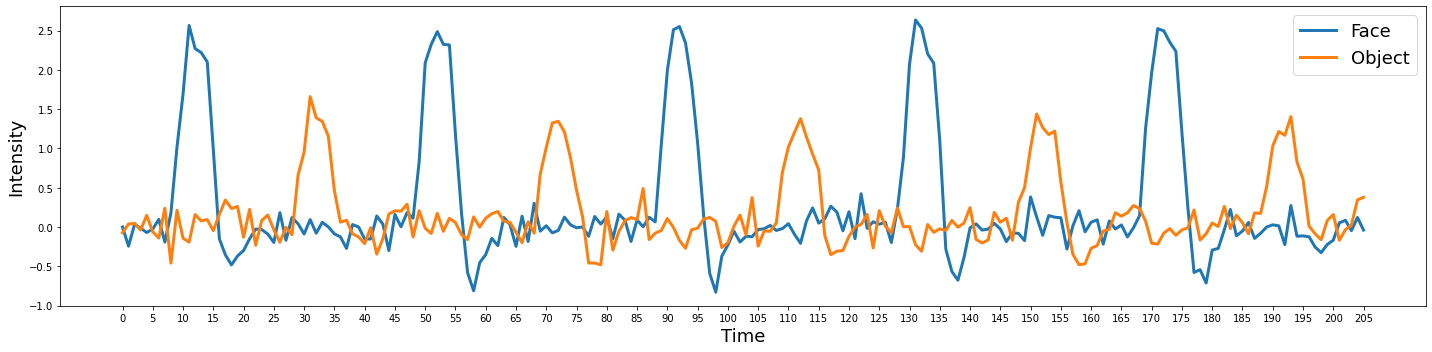

In [14]:
# Add white noise
sigma = 0.15
epsilon = sigma*np.random.randn(exp_times, tr)
categories_conv_noise = categories_conv + epsilon

plot_timeseries(categories_conv_noise, exp_times, labels=['Face', 'Object'])

이제 이 데이터를 실제 brain data라고 가정하고 사용하자.

<Figure size 432x288 with 0 Axes>

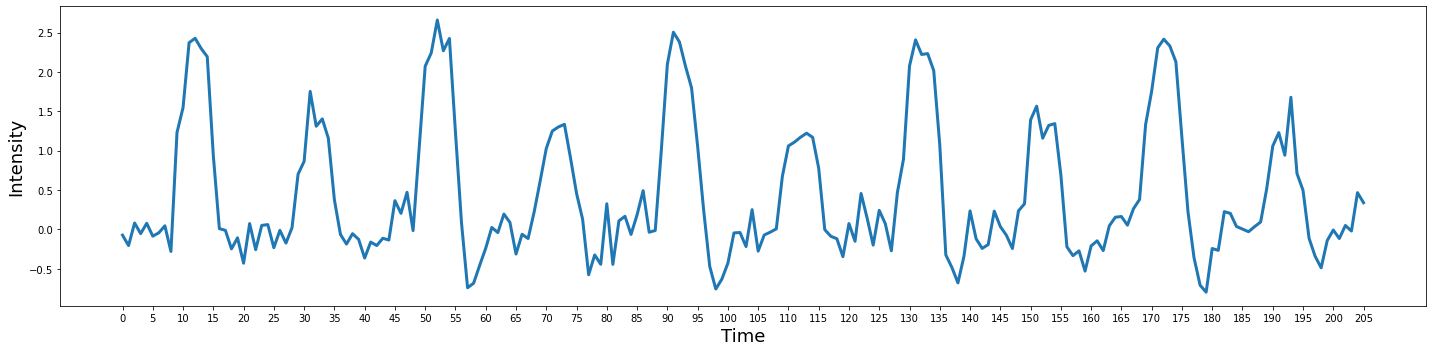

In [15]:
plt.clf()
Y = categories_conv_noise.sum(axis=1)

plot_timeseries(Y, exp_times)
plt.show()

# Construct Design Matrix

Design matrix를 만들어보자
위에서는 brain activity를 simulation 하기 위해, 즉 brain activity를 직접 만들어내기 위해서 내가 조사하고자 하는 voxel이 face에 더 민감하다는 것을 알고 있기 때문에 intesity를 반영하였지만, 그것은 그냥 brain activity를 simulation 하기 위함이였다.

지금 우리는 내가 조사하고자 하는 voxel이 어떤 자극에 대해 민감한지 잘 모르는 상황을 가정한다.
즉, 데이터 분석을 통해서 이 voxel이 어떤 자극에 더 민감한지를 밝히고자 한다.
따라서 각 category에 intensity를 1로 놓고 brain acitiy의 모형을 만든다.

이렇게 했을때, 만약 이 voxel이 face에 대해 더 민감한 반응을 보인다면, β값이 더 크게 나올것이다.

In [92]:
exp_times = 206 # 206

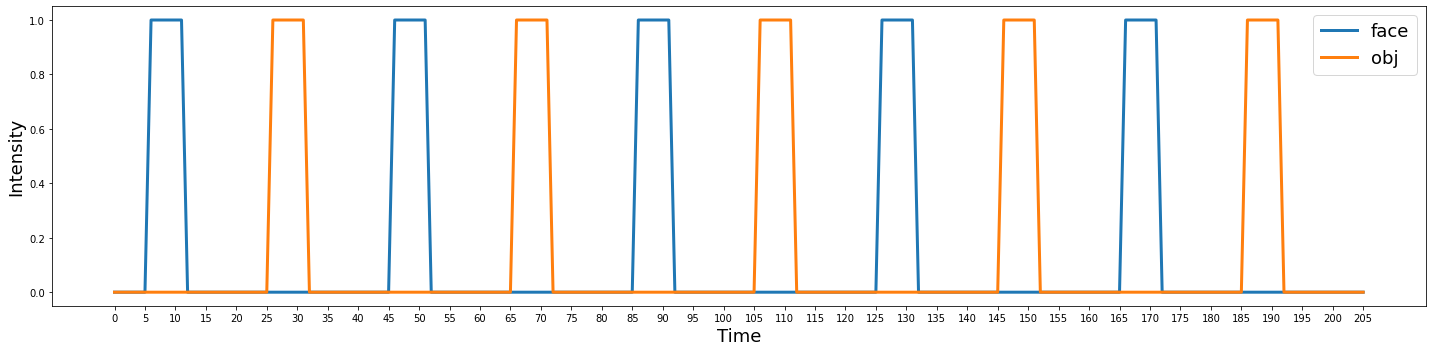

In [104]:
face = boxcar_design(start_time = face_start_time, 
                     exp_times = exp_times, 
                     intensity = 1, 
                     stimulus_time = stimulus_time, 
                     trial_time = trial_time)

obj = boxcar_design(start_time = object_start_time, 
                     exp_times = exp_times, 
                     intensity = 1, 
                     stimulus_time = stimulus_time, 
                     trial_time = trial_time)

categories = np.vstack([face,obj]).T
plot_timeseries(categories, exp_times)

plt.legend(["face", "obj"], fontsize=18)

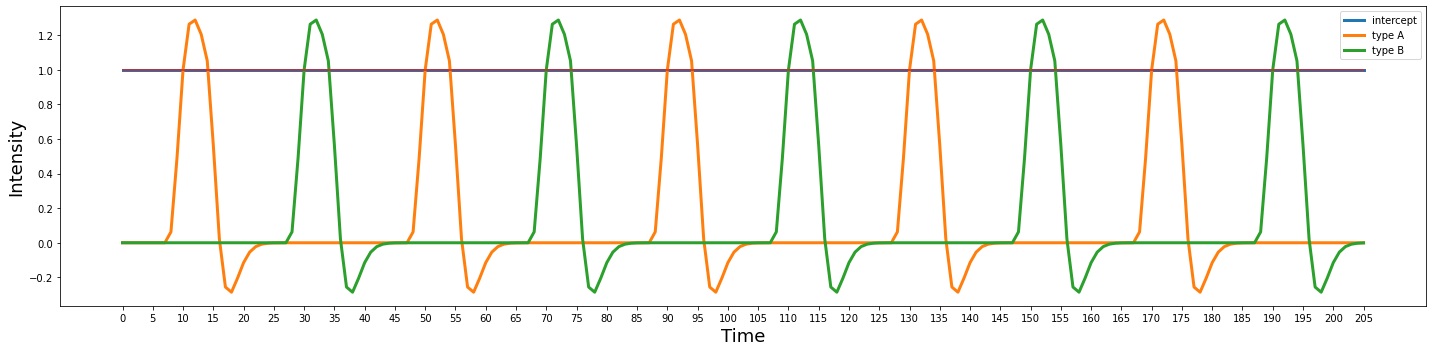

In [96]:
intercept = np.ones(exp_times) # intercept
data_length = len(intercept)
X = np.vstack([intercept, np.convolve(face, hrf)[:data_length], np.convolve(obj, hrf)[:data_length]]).T

plot_timeseries(X, exp_times)
plt.legend(["intercept", "type A", "type B"])

plt.plot(intercept)

이를 각 변수에 대해 나누고, 가로로 놓으면 다음과 같이 표현될 수 있다.

이렇게 만든 행렬이 Design Matrix X가 된다.

<Figure size 432x288 with 0 Axes>

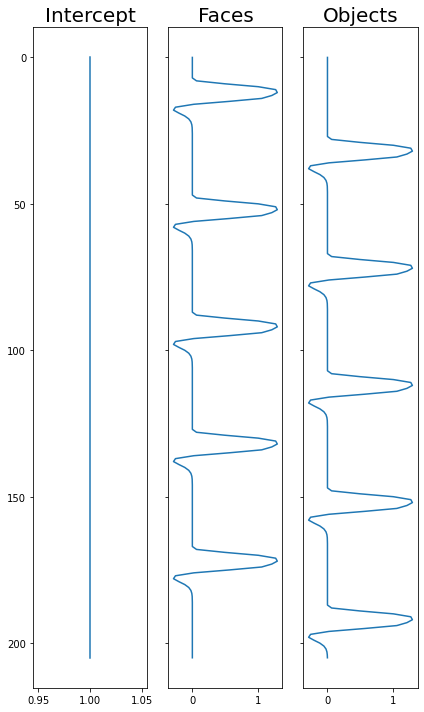

In [18]:
plt.clf()

f, a = plt.subplots(ncols=3, figsize=(6, 10), sharey=True)
a[0].plot(X[:,0], range(len(Y)))
a[1].plot(X[:,1], range(len(Y)))
a[2].plot(X[:,2], range(len(Y)))
a[0].set_title('Intercept', fontsize=20)
a[1].set_title('Faces', fontsize=20)
a[2].set_title('Objects', fontsize=20)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

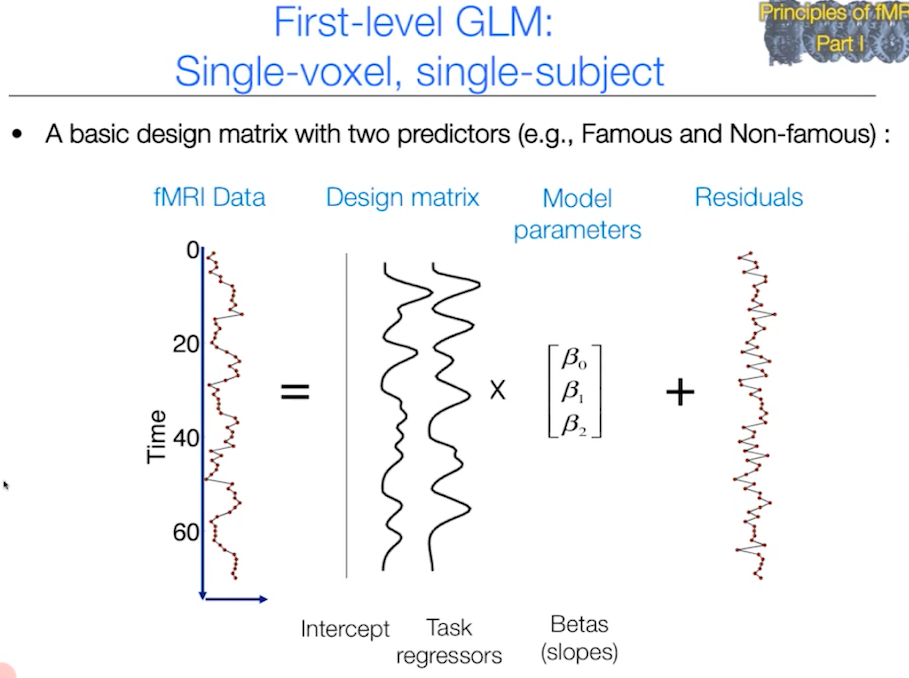

이렇게 만든 Design matrix로 다음과 같은 회귀식을 생각할 수 있다.

$$ 𝑉𝑜𝑥𝑒𝑙=𝛽_0⋅𝐼𝑛𝑡𝑒𝑟𝑐𝑒𝑝𝑡+𝛽_1⋅𝐹𝑎𝑐𝑒𝑠+𝛽_2⋅𝑂𝑏𝑗𝑒𝑐𝑡𝑠+𝜖 $$


<Figure size 432x288 with 0 Axes>

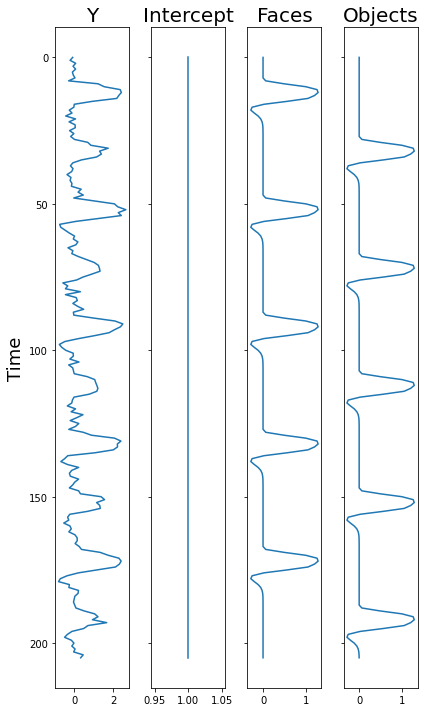

In [19]:
plt.clf()

f, a = plt.subplots(ncols=4, figsize=(6, 10), sharey=True)
a[0].plot(np.expand_dims(Y, axis=1), range(len(Y)))
a[1].plot(X[:,0], range(len(Y)))
a[2].plot(X[:,1], range(len(Y)))
a[3].plot(X[:,2], range(len(Y)))
a[0].set_ylabel('Time', fontsize=18)
a[0].set_title('Y', fontsize=20)
a[1].set_title('Intercept', fontsize=20)
a[2].set_title('Faces', fontsize=20)
a[3].set_title('Objects', fontsize=20)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

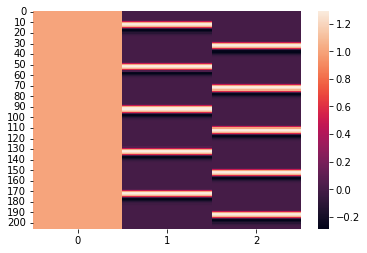

In [20]:
sns.heatmap(X)
plt.show()

# Estimate GLM


beta Faces - beta Objects: 0.86


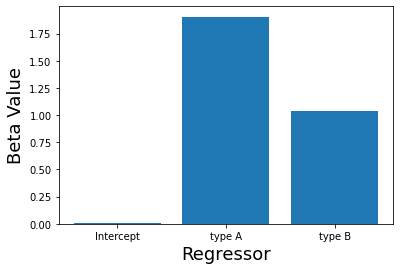

In [97]:
def ols_estimator(X, Y):
    return np.dot(np.dot(np.linalg.pinv(np.dot(X.T, X)), X.T), Y)

beta = ols_estimator(X, Y)

plt.bar(['Intercept','Faces', 'Objects'], beta)
plt.xlabel('Regressor', fontsize=18)
plt.ylabel('Beta Value', fontsize=18)

print(f'beta Faces - beta Objects: {beta[1]-beta[2]:.2}')

library를 이용하여서도 계산해보자.

Text(0, 0.5, 'Beta Value')

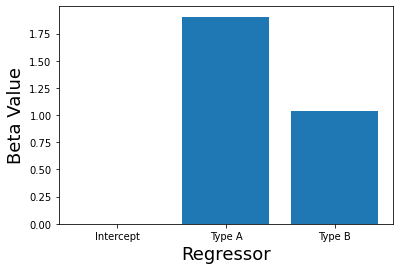

In [66]:
model = LinearRegression(fit_intercept=True)
model.fit(X, Y)

plt.bar(['Intercept','Faces', 'Objects'], model.coef_)
plt.xlabel('Regressor', fontsize=18)
plt.ylabel('Beta Value', fontsize=18)

<Figure size 432x288 with 0 Axes>

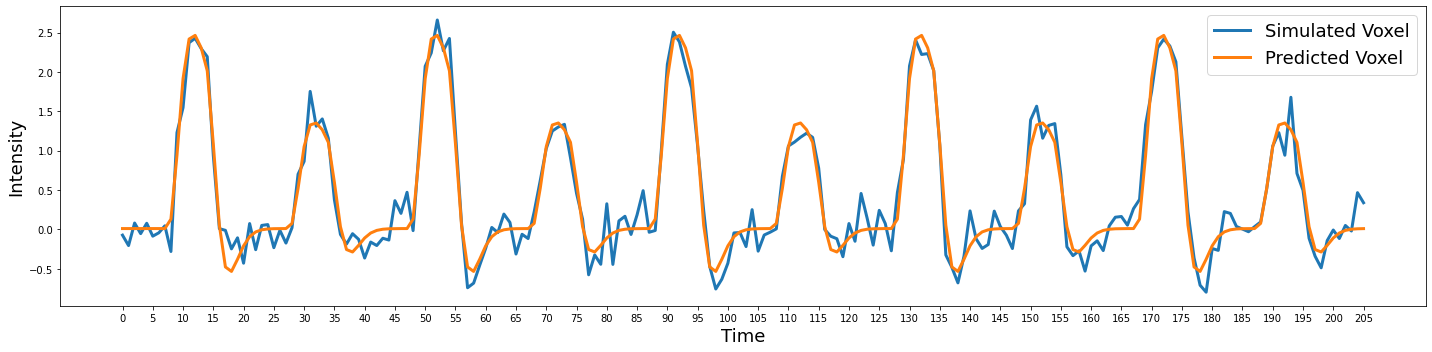

In [23]:
plt.clf()
predicted_y = np.dot(X, beta)
predicted_ts = np.vstack([Y, predicted_y]).T

plot_timeseries(predicted_ts, exp_times, labels=['Simulated Voxel', 'Predicted Voxel'])
plt.show()

# Without Humodynamic delay

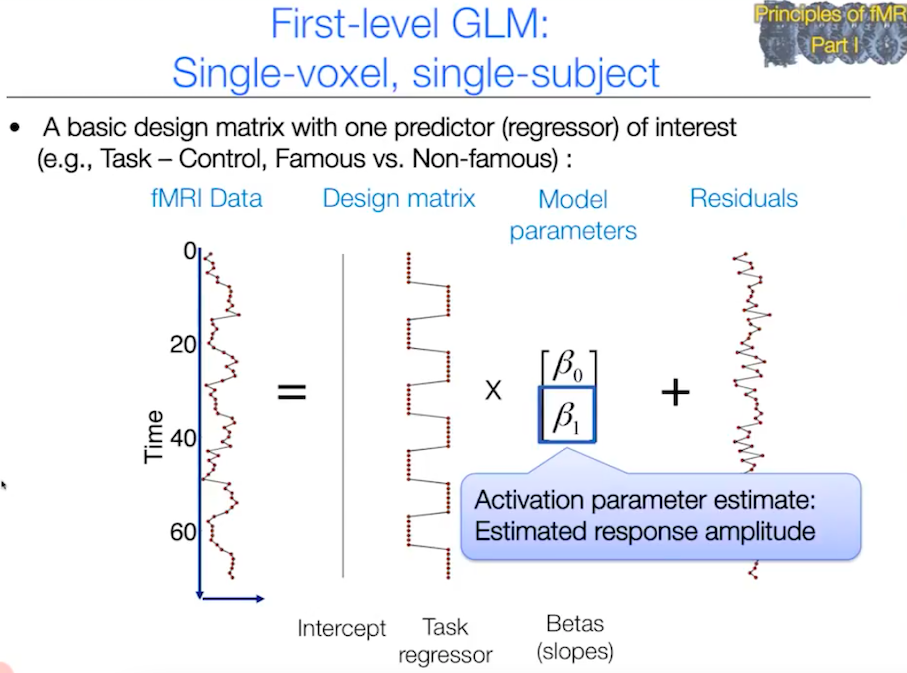

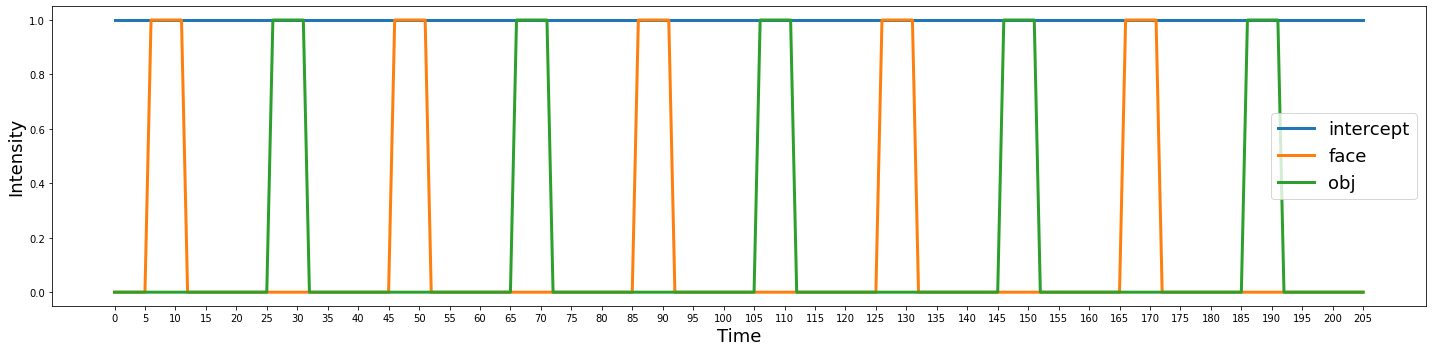

In [105]:
face = boxcar_design(start_time = face_start_time, 
                     exp_times = exp_times, 
                     intensity = 1, 
                     stimulus_time = stimulus_time, 
                     trial_time = trial_time)

obj = boxcar_design(start_time = object_start_time, 
                     exp_times = exp_times, 
                     intensity = 1, 
                     stimulus_time = stimulus_time, 
                     trial_time = trial_time)

categories = np.vstack([face,obj]).T

intercept = np.ones(exp_times) # intercept
X = np.vstack([intercept, face, obj]).T

plot_timeseries(X, exp_times)

plt.legend(["intercept","face", "obj"], fontsize=18)

<Figure size 432x288 with 0 Axes>

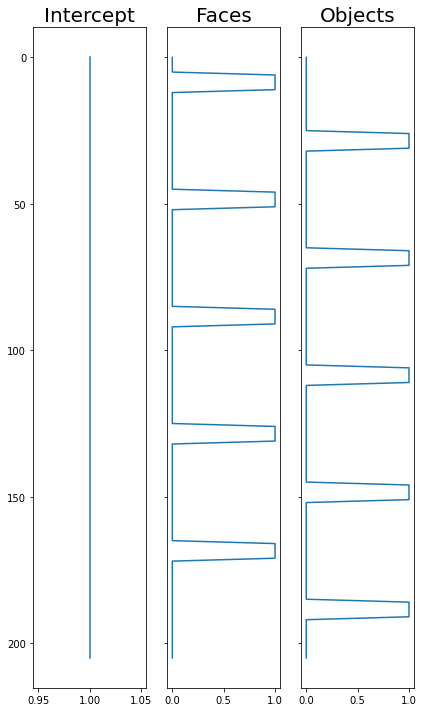

In [25]:
plt.clf()
f, a = plt.subplots(ncols=3, figsize=(6, 10), sharey=True)
a[0].plot(X[:,0], range(len(Y)))
a[1].plot(X[:,1], range(len(Y)))
a[2].plot(X[:,2], range(len(Y)))
a[0].set_title('Intercept', fontsize=20)
a[1].set_title('Faces', fontsize=20)
a[2].set_title('Objects', fontsize=20)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

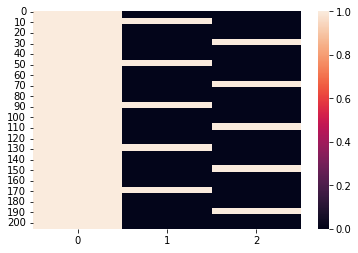

In [26]:
plt.clf()
sns.heatmap(X)
plt.show()

beta Faces - beta Objects: 0.46


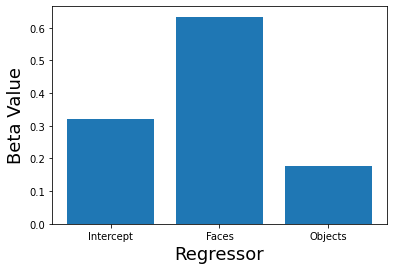

In [27]:
plt.clf()
beta = ols_estimator(X, Y)

plt.bar(['Intercept','Faces', 'Objects'], beta)
plt.xlabel('Regressor', fontsize=18)
plt.ylabel('Beta Value', fontsize=18)

print(f'beta Faces - beta Objects: {beta[1]-beta[2]:.2}')
plt.show()

<Figure size 432x288 with 0 Axes>

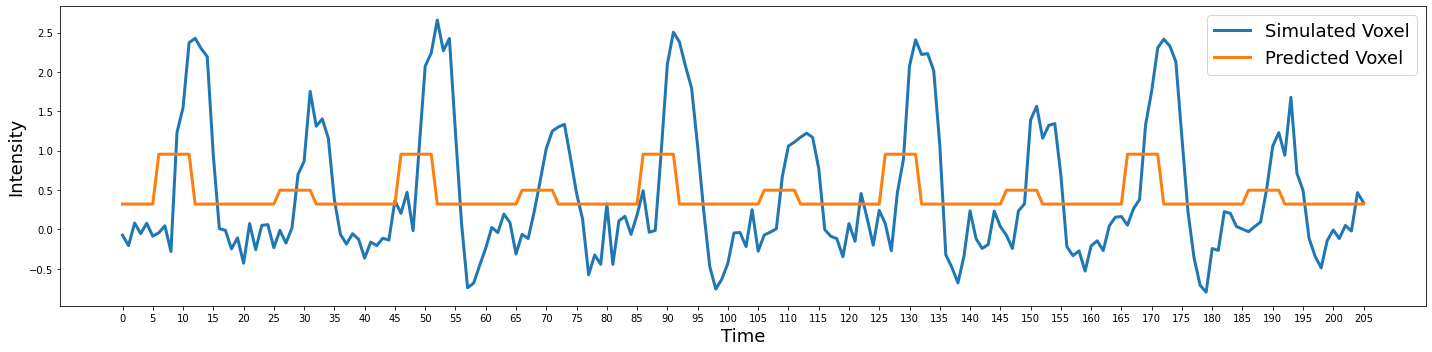

In [28]:
plt.clf()
predicted_y = np.dot(X, beta)
predicted_ts = np.vstack([Y, predicted_y]).T

plot_timeseries(predicted_ts, exp_times, labels=['Simulated Voxel', 'Predicted Voxel'])
plt.show()

# Example: Brain activity GLM

### Load Data

다음 데이터셋은 피험자로 하여금 손, 얼굴, 발을 움직여보라고 한 데이터셋이다.

다음 데이터들을 모두 다운로드하여 하나의 디렉토리 안에 집어넣고 본인이 설정한 경로를 data_dir_path에 설정하는 작업이 필요하다.

head motion data: https://drive.google.com/file/d/17ISzkLu_GexwmfT0oJycnwuEvn8BsOKE/view?usp=sharing  
behavior data: https://drive.google.com/file/d/1LCMfWoNk_yq0NN9oTB9mceaK3xUx7vg5/view?usp=sharing  
anatomy: https://drive.google.com/file/d/1bJ9eFoFWcLF1KXhUr41P31kWZJrCEINx/view?usp=sharing  
full mask: https://drive.google.com/file/d/1g8JC1BLLmGQWZTtqyWFMar6bjaHPW0Jm/view?usp=sharing  
fmri data: https://drive.google.com/file/d/1etrI6ss7hwUq1_yPfHx3rIRx7it6tOqo/view?usp=sharing  


In [29]:
data_dir_path = "/mnt/sdb2/seojin/Tutorial/LimData" # need to revise

In [30]:
func_file = image.load_img(os.path.join(data_dir_path, "pb04.LIM.scale.nii"))
anat_file = image.load_img(os.path.join(data_dir_path, "anat_final.LIM.nii.gz"))
mask_file = image.load_img(os.path.join(data_dir_path, "full_mask.LIM.nii.gz"))
head_motion = pd.read_csv(os.path.join(data_dir_path, "motion_demean.LIM.1D"), header=None)

event = pd.read_csv(os.path.join(data_dir_path, "LIM.csv"))
event = event.drop("Unnamed: 0", axis = 1)

n_scans = head_motion.shape[0] # 몇번 찍었냐
tr = 2
frame_times = np.arange(n_scans) * tr # 언제 찍혔냐
duration = []
for i in range(len(event)-1):
    duration.append(15)
duration.append(12)
event["duration"] = duration

fmri_session = Brain_Data(func_file)

In [31]:
event

trial_type       onset  duration
0        rest    0.000000        15
1        face   15.028388        15
2        rest   30.000000        15
3        foot   45.032113        15
4        rest   60.000000        15
5        Hand   75.035079        15
6        rest   90.000000        15
7        foot  105.039621        15
8        rest  120.000000        15
9        face  135.042305        15
10       rest  150.000000        15
11       Hand  165.046454        15
12       rest  180.000000        15
13       foot  195.050518        15
14       rest  210.000000        15
15       Hand  225.054068        15
16       rest  240.000000        15
17       face  255.056509        15
18       rest  270.000000        15
19       face  285.060189        15
20       rest  300.000000        15
21       Hand  315.062963        15
22       rest  330.000000        15
23       foot  345.065561        15
24       rest  360.000000        15
25       Hand  375.067620        15
26       rest  390.000000        15
27       face  405.071041        15
28       rest  420.000000        15
29       foot  435.073525        15
30       rest  450.000000        15
31       Hand  465.076762        15
32       rest  480.000000        15
33       foot  495.079595        15
34       rest  510.000000        15
35       face  525.082189        15
36       rest  540.000000        12

# Basic Design matrix

In [32]:
def get_event_byType(events, trial_type):
    """
    get event design by trial_type
    
    :param events: DataFrame, consist of onset, trial_type, duration
    
    return numpy array
    """
    box_design = np.zeros(n_scans)

    data = events[events["trial_type"] == trial_type]

    onset = data["onset"]
    duration = data["duration"]

    for trial_i in range(0, len(onset)):
        onset_ = int(onset.iloc[trial_i] / tr)
        duration_ = int(duration.iloc[trial_i] / tr)
        box_design[onset_:onset_ + duration_] = 1
    return box_design

In [33]:
np.unique(event["trial_type"])

array(['Hand', 'face', 'foot', 'rest'], dtype=object)

In [34]:
type_designs = []
for trial_type in np.unique(event["trial_type"]):
    type_design = get_event_byType(event, trial_type = trial_type)
    type_designs.append(type_design)
    
type_designs = np.array(type_designs).T

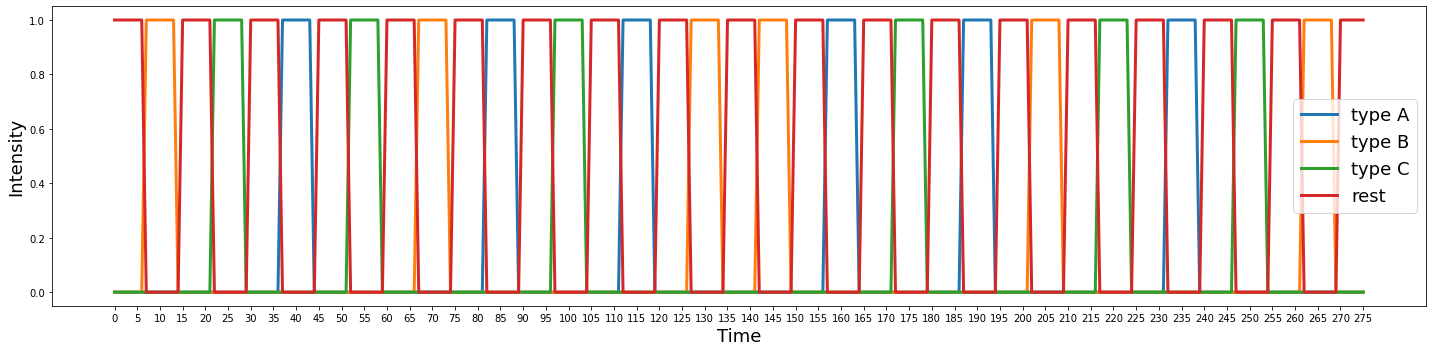

In [115]:
plot_timeseries(type_designs, n_scans, labels = np.unique(event["trial_type"]))

### Convolution(Manually)

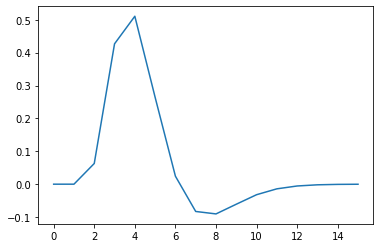

In [116]:
hrf = glover_hrf(tr, oversampling=1.0)
plt.plot(hrf)

In [37]:
convolved_regressors = []
for regressor in type_designs.T:
    convolved_regressor = np.apply_along_axis(func1d = lambda x: np.convolve(x, hrf), axis = 0, arr = regressor)
    convolved_regressors.append(convolved_regressor)
convolved_regressors = np.array(convolved_regressors).T

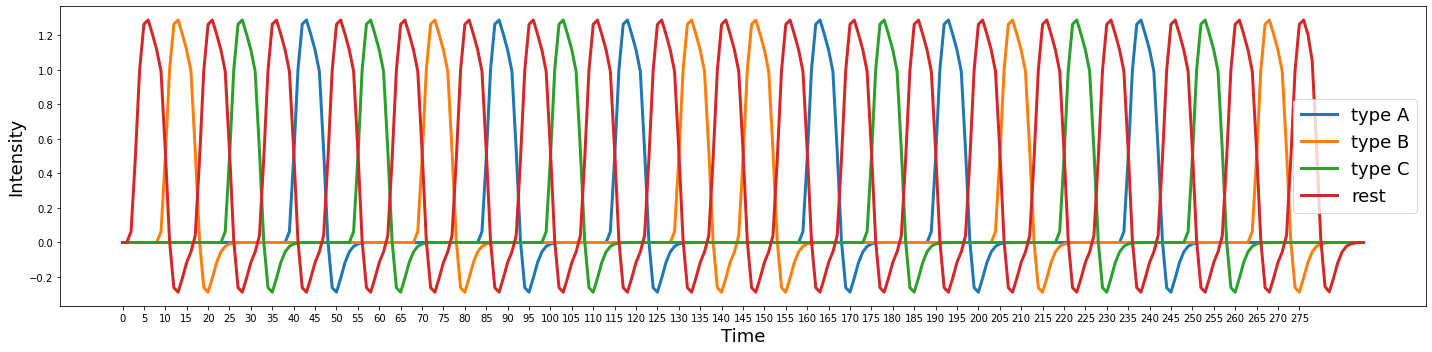

In [118]:
plot_timeseries(convolved_regressors, n_scans, labels = ["type A", "type B", "type C", "rest"])

### Convolution(libarary 이용)

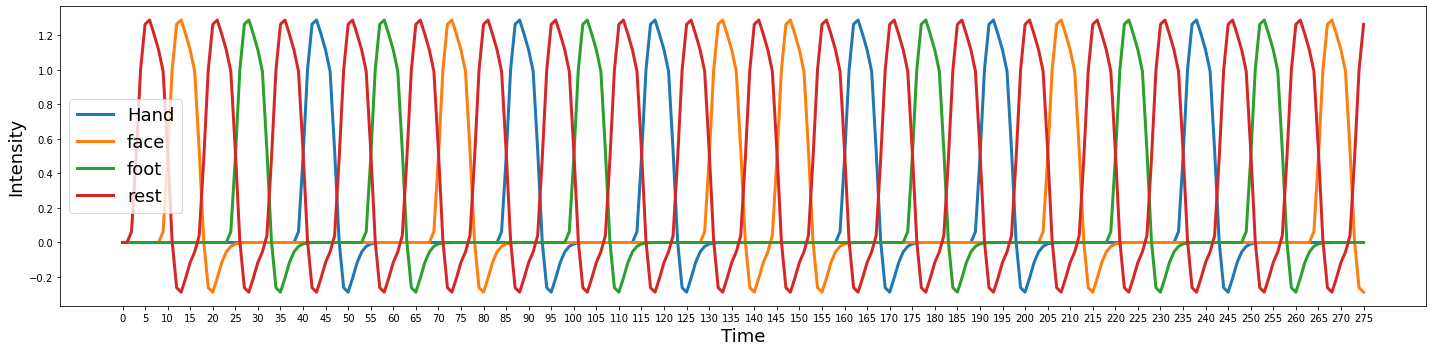

In [39]:
dm = Design_Matrix(type_designs, sampling_freq=1/tr)
dm = dm.convolve(conv_func="hrf")
dm.columns = np.unique(event["trial_type"])

plot_timeseries(np.array(dm), n_scans, labels = np.unique(event["trial_type"]))

## Intercepts

이는 baseline을 반영하거나 regressor로 모델링 되지 못하는 시간 동안의 average voxel response를 반영한다.

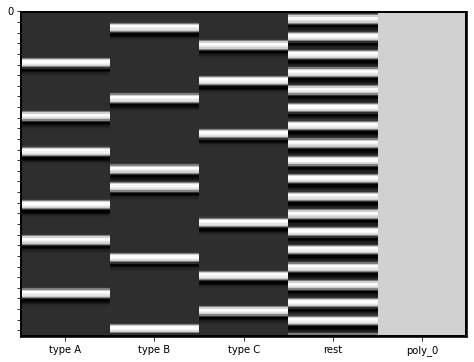

In [126]:
dm_intercept = dm.add_poly()
dm_intercept.heatmap()

## Drift

Drift는 fMRI signal에서 관찰되는데, 시간이 지나면서 느리게 voxel의 intensity가 변화하는 것을 말한다. 이는 사체에서도 관찰된다.
다음 그림은 Drift가 발생하는 fMRI signal의 예제이다. 파란색 그래프는 실제 데이터인데, 시간에 흐름에 따라 intensity가 변화하는 것을 관찰할 수 있다.(이상적인 상황이라면, 시간에 흐름과는 무관하게 fMRI Signal이 자극에 따라 변할것이다)
검은색 선은 fMRI signal을 평균하고 low-frequency drift를 고려한 것인데, drift를 고려하지 않은 predicted response(빨간색 선)에 이 검은색 선을 더해주면 초록색 선과 같은 predicted response를 얻을 수 있다.
즉, drift를 고려함으로 인하여, model의 오차가 줄어들었다.

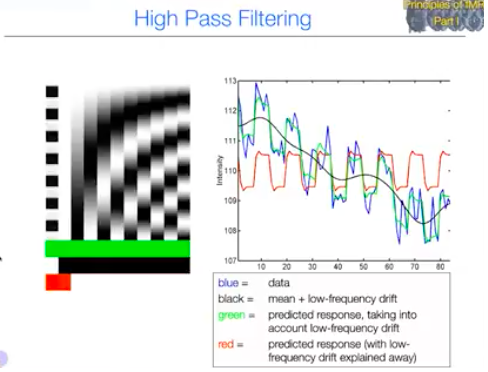

참고: https://youtu.be/DEtwsFdFwYc

Design Matrix already has 0th order polynomial...skipping


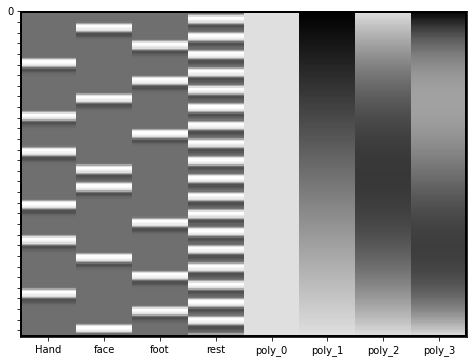

In [106]:
dm_poly = dm_intercept.add_poly(order=3, include_lower=True)
dm_poly.heatmap()

# Head motion

head motion은 그 자체로 magnetic field에서 nonlinearly distort 할 수 있다. head motion을 제거하기 위한 여러 방법이 있다.
하나는 ICA와 같은 data driven denoising algorithm을 이용하는 것이다. 다른 하나는 각 TR에 align하기 위해 적용되어질 필요가 있는 correlation의 양을 포함하는 것이다. 만약 누군가가 하나의 TR에 많이 움직였다면, realignment parameters가 크게 변화했을 것이다. 이는 보통 당신의 regression model안에 covariate로써 6개의 파라미터를 포함한다. 그러나 우리가 이미 알고 있듯이, motion은 nonlinear relationship을 가진다. 그래서 head motion으로 부터 나오는 signal에 대한 other transformations of signal을 포함하는 것이 좋다.

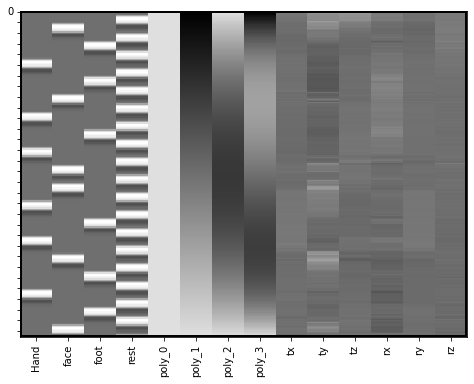

In [98]:
add_reg_names = ["tx", "ty", "tz", "rx", "ry", "rz"]
head_motion = pd.read_csv(os.path.join(data_dir_path, "motion_demean.LIM.1D"), delimiter= " ", names=add_reg_names)

dm_head_motion = pd.concat([dm_poly, head_motion], axis=1)
dm_head_motion.heatmap()

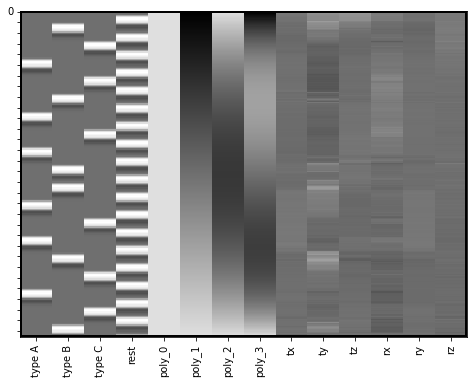

In [112]:
add_reg_names = ["tx", "ty", "tz", "rx", "ry", "rz"]
head_motion = pd.read_csv(os.path.join(data_dir_path, "motion_demean.LIM.1D"), delimiter= " ", names=add_reg_names)

dm_head_motion = pd.concat([dm_poly, head_motion], axis=1)
dm_head_motion.heatmap()

In [43]:
fmri_session.X = dm_head_motion

stat = fmri_session.regress()

In [44]:
beta = stat["beta"]

hand_beta = beta[0]
face_beta = beta[1]
foot_beta = beta[2]
rest_beta = beta[3]

### 해석

아래 그림을 보면, motor cortex 쪽이 rest에 비해 활성화 되는 것을 볼 수 있다.

In [45]:
(hand_beta - rest_beta).standardize(method='zscore').iplot(threshold=1)

interactive(children=(FloatText(value=1.0, description='Threshold'), HTML(value='Image is 3D', description='Vo…

# Nilearn fit

NlTools library가 아닌 Nilearn을 이용하여 앞의 예제 검증

<AxesSubplot:label='conditions', ylabel='scan number'>

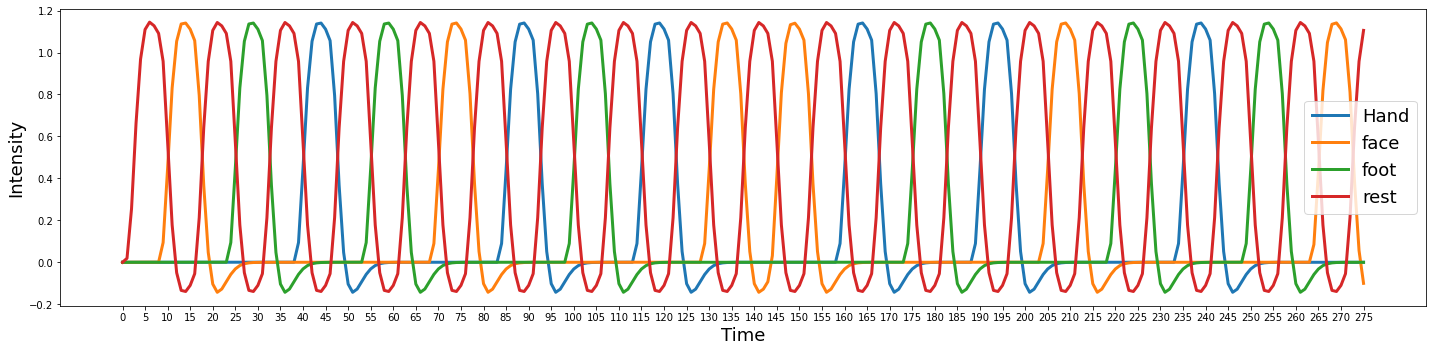

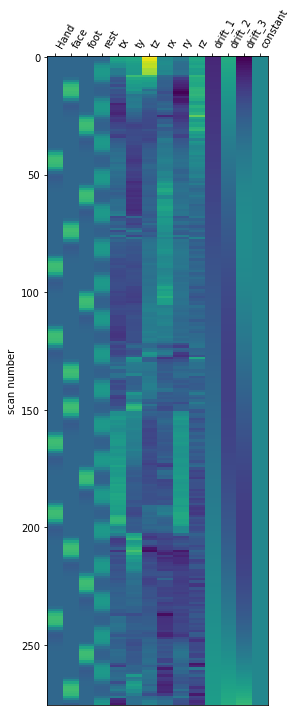

In [46]:
dsg_mat = make_first_level_design_matrix(frame_times, 
                                         event, 
                                         drift_model = "polynomial", 
                                         drift_order = 3, 
                                         add_regs = head_motion.values,
                                         add_reg_names= add_reg_names,
                                         hrf_model = "spm") # convolve, 앞의 예제와는 다른 convolution 함수 사용

plot_timeseries(np.array(dsg_mat[["Hand", "face", "foot", "rest"]]), n_scans, labels = np.unique(event["trial_type"]))

plotting.plot_design_matrix(dsg_mat)

In [47]:
fmri_glm = FirstLevelModel(mask_img = mask_file)
glm_fit = fmri_glm.fit(func_file, design_matrices = dsg_mat)

contrasts = { 
    "hand_minus_rest" :  np.concatenate(([1,0,0,-1], np.zeros(10)), axis=0),
    "face_minus_rest" :  np.concatenate(([0,1,0,-1], np.zeros(10)), axis=0)
}
z_map = glm_fit.compute_contrast(contrasts["hand_minus_rest"], output_type = "z_score")

/home/seojin/anaconda3/envs/seojin/lib/python3.9/site-packages/nilearn/plotting/html_stat_map.py:217: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  bg_img = load_mni152_template()



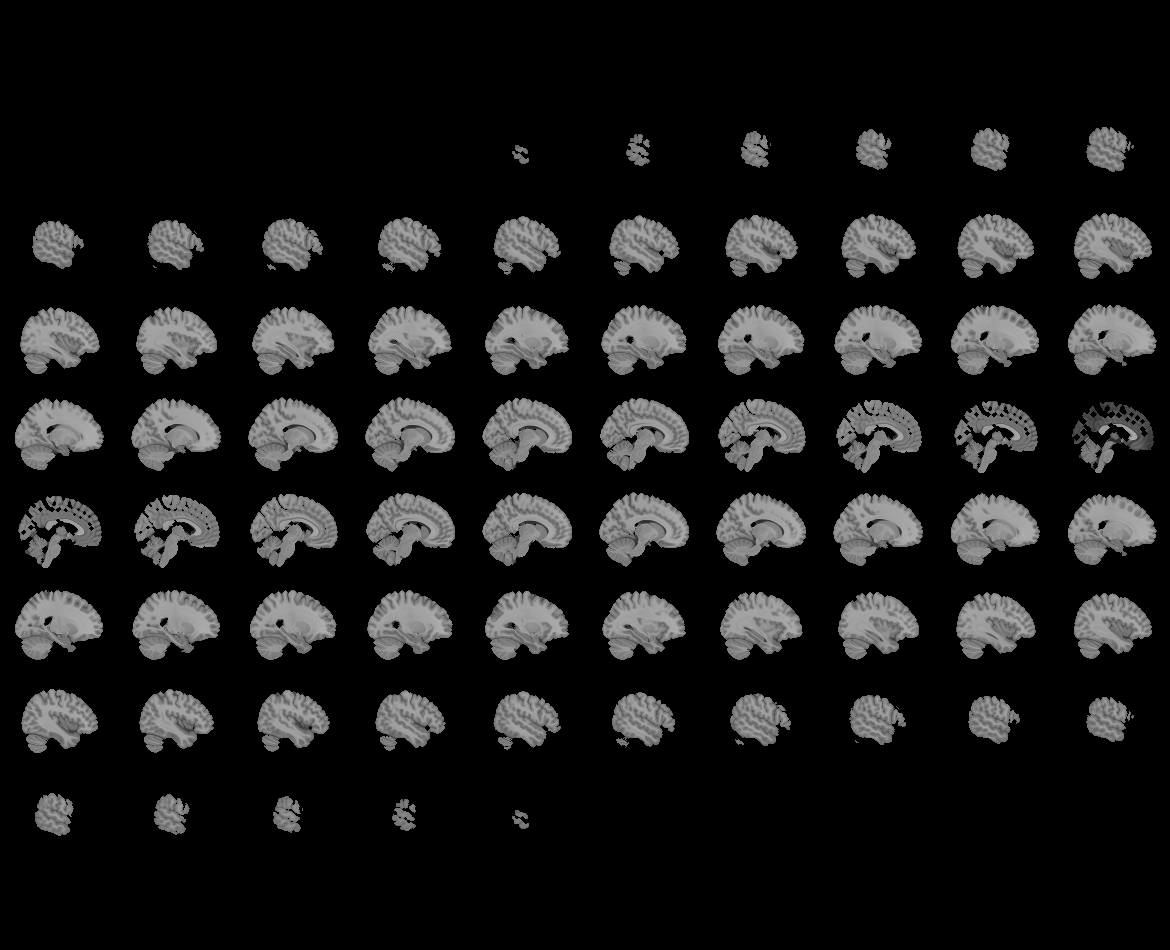
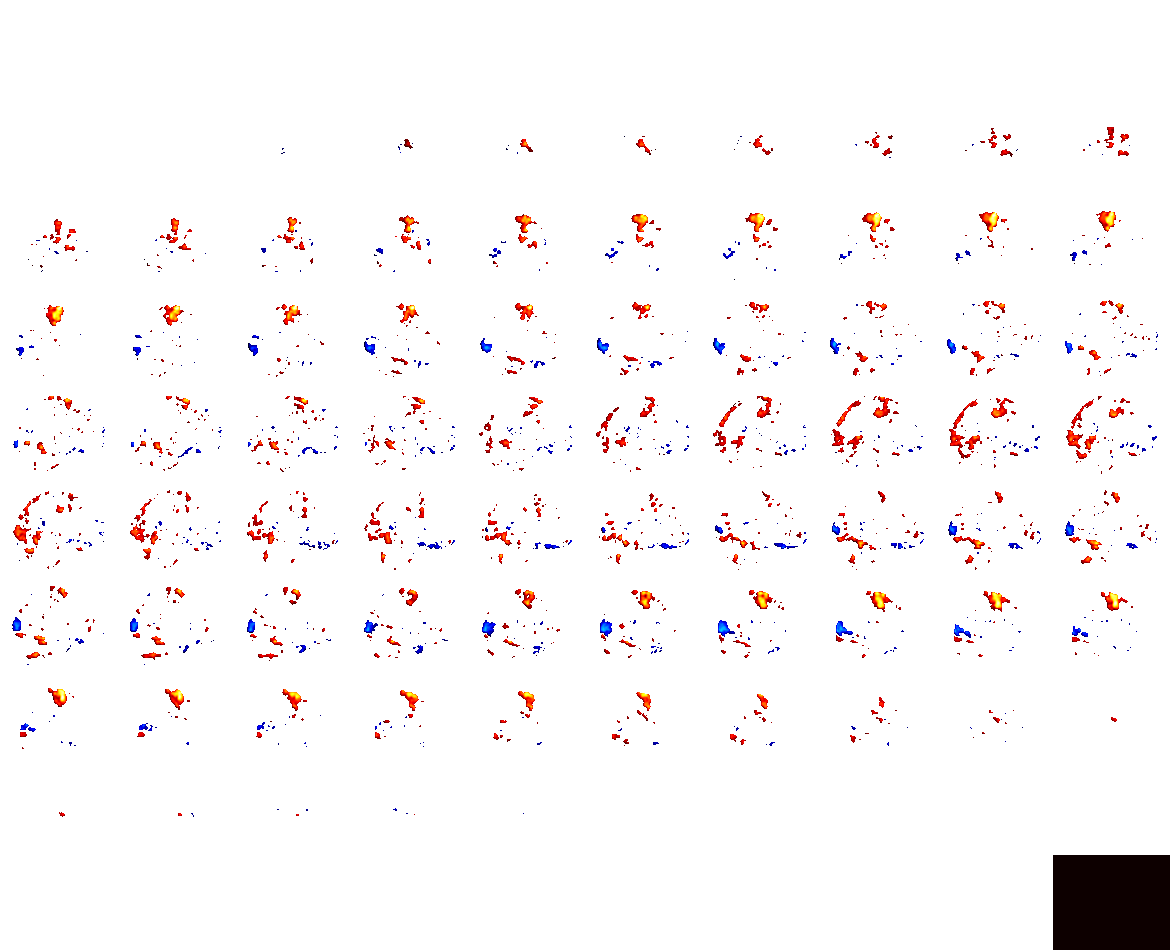

In [48]:
plotting.view_img(z_map, threshold =2.58)

# Group Analysis

# One sample t-test

Across subject에 대해서 activation이 consistently하게 유지되는지 확인하는 방법이다. 특정한 condition의 across subject에 대한 beta value를 뽑고 평균한다음 one-sample t-test를 수행하면 된다.

이는 regression 형식으로도 표현할 수 있는데, Across subject에 대해서 같은 위치에 대응되는 voxel의 beta value를 뽑았을 때(s1, s2, ...) 이 값들을 intercept로 설명할 수 있는지 확인한다. 아래와 같은 regression을 수행하여 $B_0$를 구한다면 response variable의 평균이 된다.

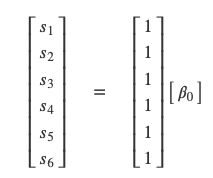

이를 선형 회귀식으로 조금 더 풀어보면, 다음과 같다.
$$ s_1 = β_0 + ε_1 $$ 
$$ s_2 = β_0 + ε_2 $$ 

...

$$ s_n = β_0 + ε_n $$ 

그런데 우리의 목표는 오차가 가장 적게나는 모델을 만드는 것이므로 위 식을 오차항으로 정리하면 다음과 같다.

$$ ε_1 = s_1 - β_0 $$ 
$$ ε_2 = s_2 - β_0 $$ 

...

$$ ε_n = s_n - β_0 $$ 

이에 대한 잔차제곱의 합은 다음과 같다.

$$ \sum_{i=1}^{n}{ε_i}^{2} = \sum_{i=1}^{n}(s_i - β_0)^2 $$

이를 $β_0$에 대하여 미분하면 다음과 같다.

$$ \frac{d\sum_{i=1}^{n}(s_i - β_0)^2}{β_0} = \sum_{i=1}^{n}(2)(s_i - β_0)(-1) = 0 $$

$$ \sum_{i=1}^{n}s_i - nβ_0 = 0 $$

$$ β_0 = \frac{\sum_{i=1}^{n}s_i}{n} $$

만약 $β_0$가 0에서 멀리 떨어져있다면, 귀무가설 "Across subject에 대해서 activation이 consistently하게 유지되지 않는다."를 기각하게 된다.


다음은 simulation 예제이다.

Gaussian distribution으로부터 데이터를 생성하고 두 그룹을 만들었다.
group1은 N(10, 2)으로부터 생성되었으며 group2는 N(5, 2)로부터 생성되었다.

각각에 대하여 beta value를 뽑고 regression을 수행한다.

In [49]:
def run_regression_simulation(x, y, paired=False):
    '''This Function runs a regression and outputs results'''
    # Estimate Regression
    if not paired:
        b, t, p, df, res = regress(x, y)
        print(f"betas: {b}")
        if x.shape[1] > 1:
            print(f"beta1 + beta2: {b[0] + b[1]}")
            print(f"beta1 - beta2: {b[0] - b[1]}")
            print(f"mean(group1): {np.mean(group1)}")
            print(f"mean(group2): {np.mean(group2)}")
            print(f"mean(group1) - mean(group2): {np.mean(group1)-np.mean(group2)}")
        print(f"mean(y): {np.mean(y)}")
    else:
        beta, t, p, df, res = regress(x, y)
        a = y[x.iloc[:,0]==1]
        b = y[x.iloc[:,0]==-1]
        out = []
        for sub in range(1, X.shape[1]):
            sub_dat = y[X.iloc[:, sub]==1]
            out.append(sub_dat-np.mean(sub_dat))
        avg_sub_mean_diff = np.mean([x[0] for x in out])
        print(f"betas: {b}")
        print(f"contrast beta: {beta[0]}")
        print(f"mean(subject betas): {np.mean(beta[1:])}")
        print(f"mean(y): {np.mean(y)}")
        print(f"mean(a): {a.mean()}")
        print(f"mean(b): {b.mean()}")
        print(f"mean(a-b): {np.mean(a - b)}")
        print(f"sum(a_i-mean(y_i))/n: {avg_sub_mean_diff}")

    # Create Plot
    f,a = plt.subplots(ncols=2, sharey=True)
    sns.heatmap(pd.DataFrame(y), ax=a[0], cbar=False, yticklabels=False, xticklabels=False)
    sns.heatmap(x, ax=a[1], cbar=False, yticklabels=False)
    a[0].set_ylabel('Subject Values', fontsize=18)    
    a[0].set_title('Y')    
    a[1].set_title('X')
    plt.tight_layout()

betas: 7.782246006488769
mean(y): 7.782246006488769


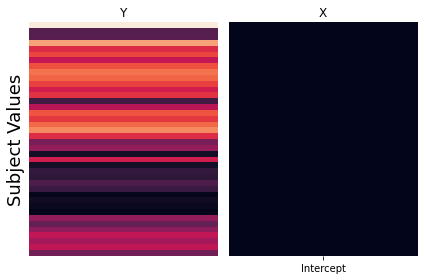

In [50]:
group1_params = {'n':20, 'mean':10, 'sd':2}
group2_params = {'n':20, 'mean':5, 'sd':2}

# 2개의 그룹에 대하여, n = 20 만큼의 sample을 normal distribution에서 뽑음
group1 = group1_params['mean'] + np.random.randn(group1_params['n']) * group1_params['sd']
group2 = group2_params['mean'] + np.random.randn(group2_params['n']) * group2_params['sd']

y = np.hstack([group1, group2])
x = pd.DataFrame({'Intercept':np.ones(len(y))})
    
run_regression_simulation(x, y)
    

## Pairwise t-test

모든 voxel에 대하여 다음과 같은 계산을 수행한다.

여기서 s는 피험자, a,b는 condition $β_0$는 contrast, 나머지 β는 subject β

dependent variable의 shape는 (#subject * #condition, 1)이 된다.  
Design matrix의 shape는 (#subject * #condition, #contrast + #subject)가 된다.

이러한 regression을 모든 voxel에 대하여 수행한다.

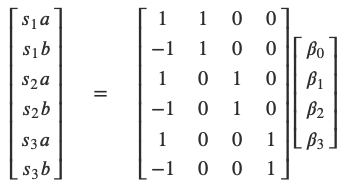


# Parametric Modulation

Parametric modulation regressor는 같은 condition의 다른 instance에 대하여 neural response의 amplitude 에서의 variability를 예측하는데 사용된다.

reference:  
https://www.bobspunt.com/resources/teaching/single-subject-analysis/parametric-modulation/

In [51]:
import numpy as np

nTR = 100 # number of TRs
onsets = [5, 25, 45, 65, 85] # trial onsets (in TRs)
ME = np.zeros(nTR)
ME[onsets] = 1

Time invariane regressor

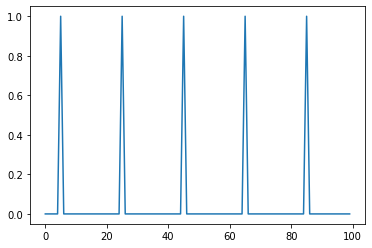

In [52]:
plt.plot(ME)

Convolve with the HRF

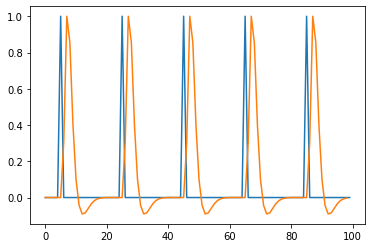

In [53]:
bf = spm_hrf(2, oversampling=1) # define the basic function
cME = np.convolve(ME, bf) # Convolve main effect with basic funcion
cME = cME[1:nTR] # Remove extra values added by convolution
cME = cME / max(cME) # scale to a max of 1 (for visual comparison)

plt.plot(ME)
plt.plot(cME)

main effect regresor의 height를 조절하는 새로운 regressor를 만들어보자

In [54]:
parameter = np.array([5, 3, 1, 7, 1.5]) # the parameter (size corresponds to onsets)
PM = np.zeros(nTR) 
PM[onsets] = parameter / max(parameter) # puts same scale as main effect

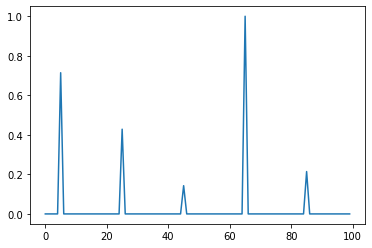

In [55]:
plt.plot(PM)

Convolve with the HRF

In [56]:
cPM = np.convolve(bf, PM) # convolve with HRF
cPM = cPM[:nTR] # remove extra values added by convolution
cPM = cPM / max(cPM) # scale to a max of 1 (for visal comparison)

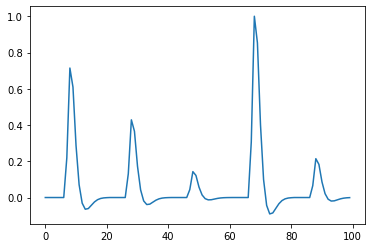

In [57]:
plt.plot(cPM)

Parametric modulation regressor는 main effect regressor와 강하게 correlated 되어 있다.

Collinear regressor는 regression model을 추정하는 것에 대하여 문제가 될 수 있다.
main effect의 height를 조절하기 전에 parameter를 orthogonalizing 함으로써 correlation을 없앨 수 있다.

가장 간단한 방법은 de-mean하는 것이다.(모든 값을 mean으로 빼어 center값이 0 되게끔 한다)

In [58]:
oparameter = parameter - np.mean(parameter) # de-mean the parameter
oPM = np.zeros(nTR) # another vector of zeros
oPM[onsets] = oparameter / max(oparameter) # re-scale
coPM = np.convolve(bf, oPM) # convolve
coPM = coPM[:nTR] # remove extra values
coPM = coPM / max(coPM) # re-scale

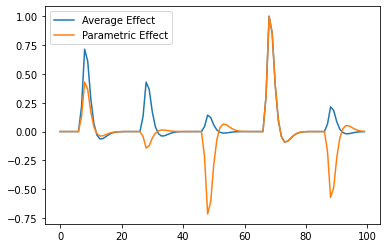

In [59]:
plt.plot(cPM)
plt.plot(coPM)

plt.legend(["Average Effect", "Parametric Effect"])

SPM에서 parametric modulation은 자동적으로 orthogonalized 해준다.
그래서 손으로 de-mean을 할필요는 없다. 하지만 주의할 점이 하나이상의 parametric modulator를 이용할 때, SPM은 serial orthogonalisation을 사용한다는 것이다.

refence: https://imaging.mrc-cbu.cam.ac.uk/imaging/ParametricModulations

# Nilearn parametric modulation

https://neurostars.org/t/parametric-modulation-in-nistats/3392/2

In [60]:
from nilearn.glm.first_level import make_first_level_design_matrix, FirstLevelModel

기본 Regresor

<AxesSubplot:label='conditions', ylabel='scan number'>

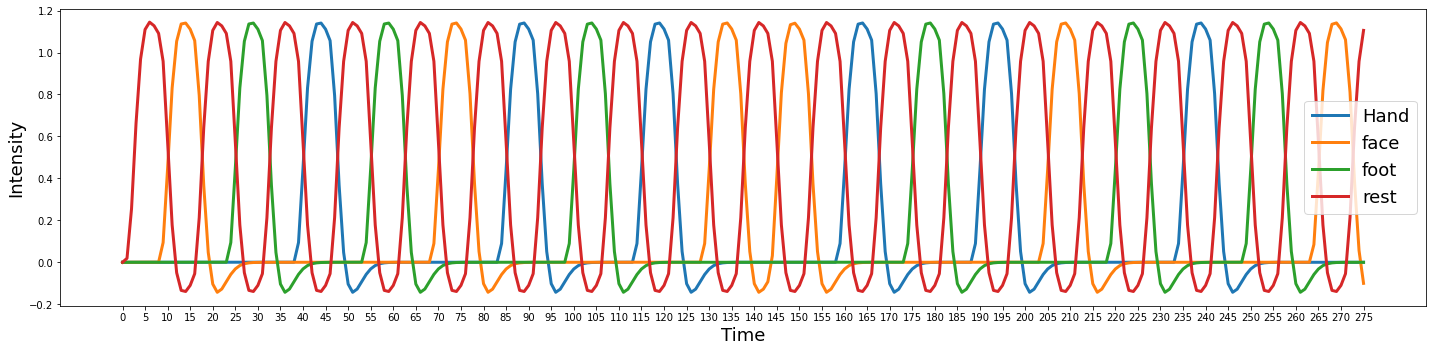

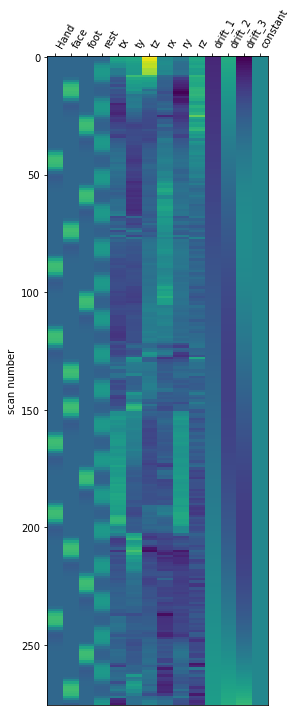

In [61]:
dsg_mat = make_first_level_design_matrix(frame_times, 
                                         event, 
                                         drift_model = "polynomial", 
                                         drift_order = 3, 
                                         add_regs = head_motion.values,
                                         add_reg_names= add_reg_names,
                                         hrf_model = "spm") # convolve, 앞의 예제와는 다른 convolution 함수 사용

plot_timeseries(np.array(dsg_mat[["Hand", "face", "foot", "rest"]]), n_scans, labels = np.unique(event["trial_type"]))

plotting.plot_design_matrix(dsg_mat)

modulation regressor

In [62]:
modulation = np.ones(len(event))

modulation[1] = 10

modulation[3] = 10

modulation_event = event.copy()
# modulation_event["modulation"] = modulation / np.mean(modulation)
modulation_event["modulation"] = modulation / np.max(modulation)
modulation_event["modulation"] = modulation_event["modulation"] - np.mean(modulation_event["modulation"])

A 'modulation' column was found in the given events data and is used.


<AxesSubplot:label='conditions', ylabel='scan number'>

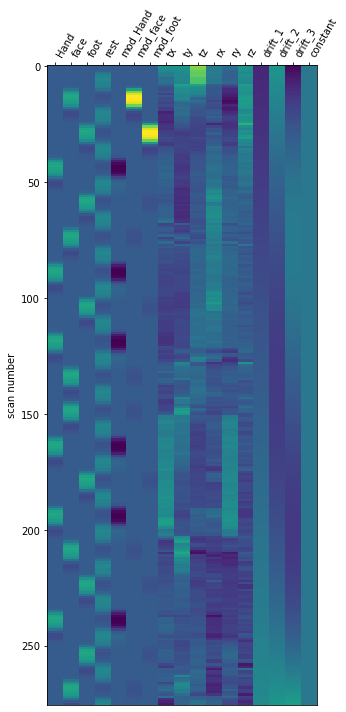

In [63]:
# create design matrix with modulation
modulation_dsg_mat = make_first_level_design_matrix(frame_times, 
                                         modulation_event, 
                                         drift_model = "polynomial", 
                                         drift_order = 3, 
                                         add_regs = head_motion.values,
                                         add_reg_names= add_reg_names,
                                         hrf_model = "spm") # convolve, 앞의 예제와는 다른 convolution 함수 사용

# remove modulation column
normal_events = modulation_event[["onset", "duration", "trial_type"]]

# create normal design matrix with modulation column added
# this assumes that you have one trial type (trial_type), so 
# you'll need to edit the regs and names if not

add_regs = np.c_[modulation_dsg_mat[["Hand", "face", "foot"]].to_numpy(), head_motion.values]
add_regs_names = ["mod_Hand", "mod_face", "mod_foot"] + add_reg_names
final_dsg_mat = make_first_level_design_matrix(frame_times,
                                              normal_events,
                                               drift_model = "polynomial", 
                                               drift_order = 3, 
                                               add_regs = add_regs,
                                               add_reg_names= add_regs_names,
                                              )

plotting.plot_design_matrix(final_dsg_mat)

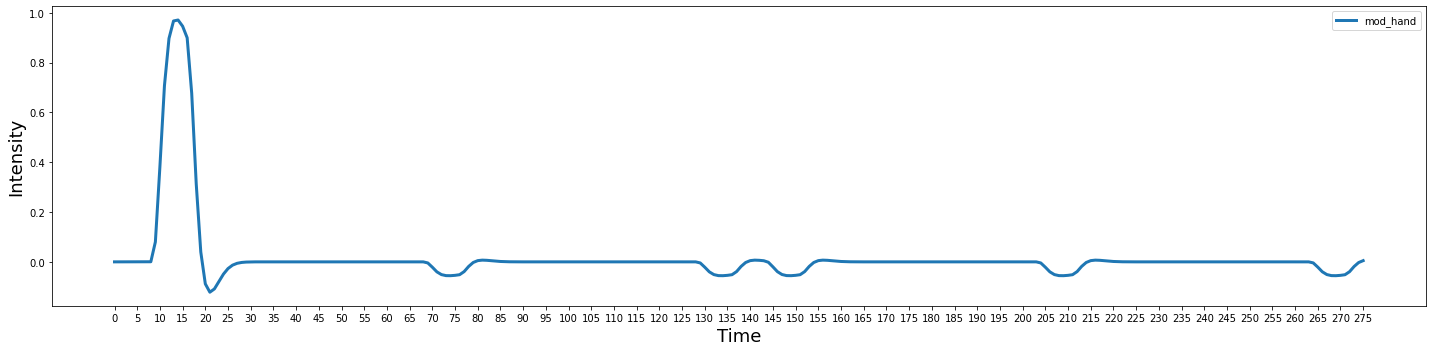

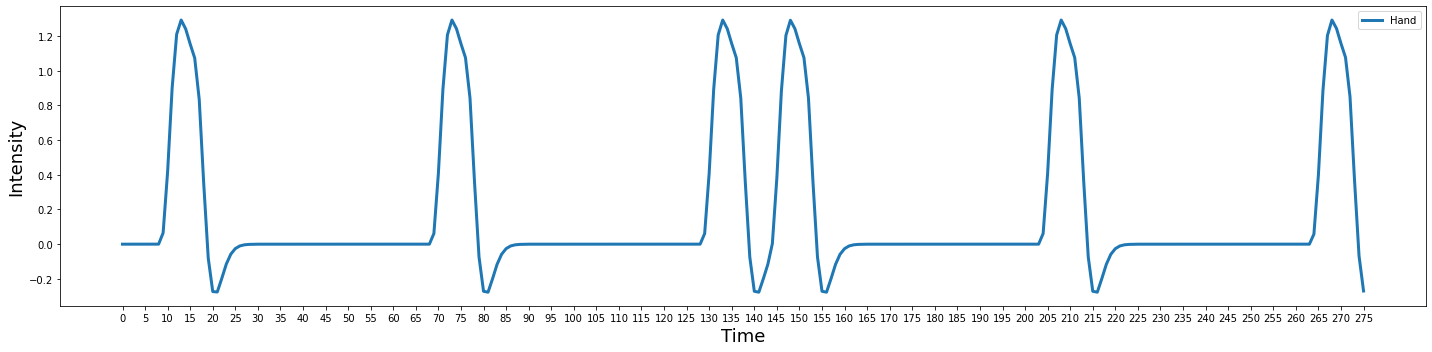

In [64]:
plot_timeseries(np.array(final_dsg_mat["mod_face"]), n_scans)
plt.legend(["mod_hand"])

plot_timeseries(np.array(final_dsg_mat["face"]), n_scans)
plt.legend(["Hand"])